In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import pandas as pd
from random import choice

# Pricing Project


#### Team members:
* Davide Beretta 
* Francesco Landini
* Federico Bucci
* Simen Salomonsen
* Siv Cartland Hansen

## Step 1: Environment

First the environment is set up to model the website interactions with the customers. For each customer type different random variables are specified.  

To demonstrate how it works, different tests and examples will be shown along the way. 

In [175]:
# Simulation of a customer visiting our products

def simulate_episode(
    init_active_node, click_probabilities, conversion_rates, n_steps_max=5
):
    """
    Takes as input
    1. the initial active node i.e. the primary product the customer has landed on (and bought!)
    2. the probability matrix of a user clicking on the secondary products
    3. the probabilies of a user bying the 5 products (conversion rates)
    4. the max time steps, which is 5 as there are 5 products that can possibly be visited

    Then returns the history of which nodes have been activated.

    NB heavily inspired by the first lab from part 4 on webeep.

    """
    # initialize
    click_prob_matrix = click_probabilities.copy()
    n_nodes = np.shape(click_prob_matrix)[0]

    # convert initial_active_node to array of 1s and 0s
    initial_active_nodes = np.zeros(n_nodes)
    initial_active_nodes[init_active_node] = 1

    # first row in this dataset is just the initial active nodes
    history = np.array([initial_active_nodes])

    # here we store all the activated nodes in our episode
    active_nodes = initial_active_nodes

    # nodes that have been activated in this timestep:
    newly_active_nodes = active_nodes

    # initialize time
    t = 0

    # Iterate over steps
    # terminate once we don't have any nodes that can be activated.
    
    # save data regarding whether or note we make conversion
    x = [[] for _ in range(n_nodes)]
    x[init_active_node].append(1)
    # save data regarding whether or not the customer clicks
    
    
    while t < n_steps_max and np.sum(newly_active_nodes) > 0:

        # select the rows related to the active nodes 
        p = (click_prob_matrix.T * newly_active_nodes).T
        
        # compute value of activated edges by sampling against click_probabilities 
        activated_edges = p > np.random.rand(p.shape[0], p.shape[1])
        
        # Remove from prob_matrix all the values of the prob related to the previously activated nodes
        click_prob_matrix = click_prob_matrix * ((p != 0) == activated_edges)
        newly_clicked_on_nodes = (np.sum(activated_edges, axis=0) > 0) * (1 - active_nodes)
        # sample against conversion rates 
        newly_active_nodes = newly_clicked_on_nodes * conversion_rates > np.random.rand(n_nodes)
        # check and save whether we made a conversion
        for p in range(5):
            if newly_clicked_on_nodes[p] == 1:
                if newly_active_nodes[p] == 1:
                    x[p].append(1)
                else:
                    x[p].append(0)
        
        active_nodes = np.array(active_nodes + newly_active_nodes) 

        history = np.concatenate((history, [newly_active_nodes]), axis=0)

        t += 1

    return history, x


In [176]:
# TEST

# assume the customer lands on product 1 and buys it
init_active_node = 0

# random probabilities of the customer clicking on the secondary products
click_probs = np.array(
    [
        [0, 1, 0.5, 0, 0],
        [1, 0, 0, 0.5, 0],
        [0, 0, 0, 1, 0.5],
        [0, 1, 0.5, 0, 0],
        [0.5, 1, 0, 0, 0],
    ]
)

# random conversion rates for the chosen price-levels (and the relevant customer type)
conversion_rates = [0.5, 0.4, 0.3, 0.1, 0.8]

# See which nodes are activated
his,x = simulate_episode(init_active_node, click_probs, conversion_rates)
print("history: ", his)
print("x: ", x) # dataset showing that given a customer clicked on the product, did we make a conversion (y/n)

history:  [[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
x:  [[1], [0], [0], [], []]


In [177]:
class Environment():

    def __init__(self, 
                conversion_rates, 
                margins, 
                click_probabilities, 
                no_items_bought,
                alpha_params,
                N_params
                ):
        '''
        Takes as input
        1. Conversion rates for each price-level (3-dim matrix)
        
        2. Margins for the products at the different price-levels 
        
        3. Probabilities of the user visiting other products (one graph for each customer type)
        
        4. The expected number of items a customer will buy for each customer type and product type 
           (used as input for the Poisson process)
        
        5. Alpha-values representing the expected fractions of the customers landing on the product pages (a1-a5) and competitor pages a0
        
        6. The expected daily number of potential customers (3 different types) 
           This is used to draw the daily number of customers each day 
        '''
        
        self.conversion_rates = conversion_rates 
        self.margins = margins 
        self.click_probabilities = click_probabilities
        self.no_items_bought = no_items_bought
        self.alpha_params = alpha_params
        self.N_params = N_params
            
    # model interaction with learner
    # round takes as input the chosen arms/prices and returns a stochastic reward
    def round(self, arms, init_product, features):
        '''
        Arms are the indices of the chosen price-levels for each product, e.g. [0,1,1,2,4] 
        Init_product is the product the customer initially lands on 
        Features are the binary features of the customer e.g. [0,0] or [0,1]
        '''
        
        # Determine the class of the user based on the features
        # NB I have just chosen some random customer types 
        if features[0] == 0 & features[1] == 0:
            context = 0
        elif features[0] == 1 & features[1] == 1:
            context = 1
        else: context = 2
        
        # check if customer buys the primary product, if yes, trigger episode 
        buy = np.random.binomial(n=1,p = self.conversion_rates[context, arms[init_product], init_product])

        # Rewards per product for current day
        rew_per_prod = np.array([0 for _ in range(5)], dtype=float)

        ################ the customer buys the initial primary product ################
        if buy: 
            # get conversion rates as a vector (for these prices and this context)
            cr = np.zeros(5)
            for i,j in zip(arms, range(5)):
                cr[j] = self.conversion_rates[context, i,j]
            click_probs = self.click_probabilities[context,:,:]
            
            # let the customer move along the graph (stochastically)
            history, x = simulate_episode(init_product, click_probs, cr)

            # draw the number of items the customer buys
            n_items_sold = np.zeros(5)
            for array in history: 
                # the number of items sold follows a Poisson distribution 
                # add and subtract 1 to make sure it is not zero! 
                lambdas = self.no_items_bought[context,:]-np.ones(5)
                n_items_sold += array*(np.random.poisson(lambdas)+np.ones(5))
            
            # compute reward
            reward = 0
            for i in range(5):
                reward += n_items_sold[i]*self.margins[arms[i], i]
                rew_per_prod[i] += n_items_sold[i]*self.margins[arms[i],i]

        ################ does NOT buy the initial primary product ################
        else: 
            x = [[] for _ in range(5)]
            x[init_product].append(0)
            history = np.zeros(5)
            n_items_sold = np.zeros(5)
            reward = 0
        
        return history, n_items_sold, reward, x, rew_per_prod
    
    def round_entire_day(self, arms):
        '''
        collects observations for a whole day - uses function defined above 

        Takes as input: 
        arms: The chosen price-levels e.g. [0,1,1,2,4]
        
        '''
        # store whether or not we make a conversion
        X = [[] for _ in range(5)]
        
        # Draw how many customers we have this day 
        Ns = np.random.poisson(self.N_params)  # type 1, 2,  3

        # Draw how many of each type lands on each product page 
        #print("Alphas: ", self.alpha_params)
        alpha_sampled = [np.random.dirichlet(self.alpha_params[0,:]),    # type 1
                        np.random.dirichlet(self.alpha_params[1,:]),    # type 2
                        np.random.dirichlet(self.alpha_params[2,:])]    # type 3

        # Get observations for each type
        context_experiments = []
        episodes_dataset = []
        n_items_dataset = []
        types = ["type1", "type2", "type3"] 
        
        # Record of reward per product for current day
        sum_rew_per_prod = np.array([0 for _ in range(5)], dtype=float)

        # Allocate space for saving the dataset for each feature
        features_dataset = dict()
        features_dataset[(0,0)] = {"n_items":[], "X":[[] for _ in range(5)],"N_customers":0, "reward":0}
        features_dataset[(0,1)] = {"n_items":[], "X":[[] for _ in range(5)],"N_customers":0,"reward":0}
        features_dataset[(1,0)] = {"n_items":[], "X":[[] for _ in range(5)],"N_customers":0,"reward":0}
        features_dataset[(1,1)] = {"n_items":[], "X":[[] for _ in range(5)],"N_customers":0,"reward":0}
        
        for t, N, a in zip(types, Ns, alpha_sampled):
            sum_result = [np.zeros(5), 0]
            
            for i in range(np.abs(N)): # Sampling based on distribution so edge-case can cause draws to be negative
                # Draws a landing-product based on distribution of alphas
                landing_product = np.random.choice(np.arange(6), 1, p=a)[0]

                # Checks if product is one of our products
                if(landing_product < 5):

                    # The learner needs to observe the set of features for each observation (so it can learn it later)
                    # therefore the the featurespace is defined below for each customer-type
                    if t == "type1":
                        f = (0,0)
                    elif t == "type2":
                        f = (1,1)
                    else: 
                        random_choice = np.random.randint(0,1+1)
                        f = [(0,1), (1,0)][random_choice] # randomly output a mixed type
                    
                    # Runs simulation for given customer
                    round_his, round_items, round_rew, x, round_rew_per_prod = self.round(arms, landing_product, f)
                    
                    # Stores result for individual customer 
                    sum_result[0] += round_items
                    sum_result[1] += round_rew
                    episodes_dataset.append(round_his)
                    X = [X[i]+x[i] for i in range(5)]
                    n_items_dataset.append(round_items)
                    sum_rew_per_prod += round_rew_per_prod
                    
                    # Store dataset for each featurecombination
                    features_dataset[f]["X"] = [features_dataset[f]["X"][i]+x[i] for i in range(5)]
                    features_dataset[f]["n_items"].append(round_items)
                    features_dataset[f]["N_customers"] += 1 
                    features_dataset[f]["reward"]+=round_rew
                    
            # Stores results from simulation for each user class
            context_experiments.append(sum_result)

        # return dataset and total reward for that day 
        total_reward = np.sum([l[1] for l in context_experiments])
        data = context_experiments 
            
        return data, episodes_dataset, total_reward, X, n_items_dataset, alpha_sampled, Ns, features_dataset, sum_rew_per_prod

#### Initialize parameters 
 

In [178]:
# First initialize the click probabilities 
n_products = 5
n_prices   = 4
n_contexts = 3

graph_1 = np.random.rand(n_products,n_products) # customer type 1
graph_2 = np.random.rand(n_products,n_products) # customer type 2
graph_3 = np.random.rand(n_products,n_products) # customer type 3

graph = np.array([graph_1, graph_2, graph_3])
print("Dense graph for customer type 1: \n", graph_1)

# However only two products are shown and we already know these as well as the order (i.e. which probability to scale by lambda)
# as I assume the company does not initially know the 3 customer types (we need to learn it from the data),
# then I have only specified 1 matrix specifying which products are the first and second secondary products. 
lambda_ = 3/4

# Fully connected graph
primary_secondary_order = [[0,1,lambda_, 0, 0],  
                            [1,0,0,lambda_, 0 ],
                            [0,0,0, 1, lambda_],
                            [0,1,lambda_, 0, 0],
                            [lambda_,1,0, 0, 0]]

### UNCOMMENT THE FOLLOWING PART TO RUN THE NOTEBOOK WITH A SPARSE GRAPH
""" 
# Sparse graph
primary_secondary_order = [[0,1,0, 0, 0],  
                            [1,0,0,lambda_, 0 ],
                            [0,0,0, 1, lambda_],
                            [0,1,0, 0, 0],
                            [0,0,0, 0, 0]]
"""

# The final probabilities of the customers clicking on the secondary products can then be computed: 
click_prob = graph*primary_secondary_order
print("\nClick probabilities for customer type 1: \n",click_prob[0,:,:] )


Dense graph for customer type 1: 
 [[0.54726206 0.05408017 0.8886266  0.53418422 0.1204851 ]
 [0.27487937 0.2146715  0.42693975 0.91488572 0.08150925]
 [0.9084125  0.92451647 0.00564448 0.11782575 0.90352876]
 [0.32782782 0.23476854 0.05435945 0.01974754 0.6132851 ]
 [0.4470149  0.73118984 0.29832685 0.05715199 0.22348336]]

Click probabilities for customer type 1: 
 [[0.         0.05408017 0.66646995 0.         0.        ]
 [0.27487937 0.         0.         0.68616429 0.        ]
 [0.         0.         0.         0.11782575 0.67764657]
 [0.         0.23476854 0.04076958 0.         0.        ]
 [0.33526117 0.73118984 0.         0.         0.        ]]


In [179]:
# Initialize other parameters

# define conversion rates for each price-level of each product (different for each customer type)
conversion_rates_1 = [[0.80, 0.60, 0.70, 0.40, 0.90],  # customer type 1
                       [0.70, 0.40, 0.55, 0.30, 0.70],
                       [0.60, 0.20, 0.40, 0.25, 0.60],
                       [0.50, 0.10, 0.30, 0.20, 0.50]]
conversion_rates_2 =  [[0.65, 0.60, 0.80, 0.40, 0.90],  # customer type 2
                       [0.55, 0.40, 0.75, 0.30, 0.70],
                       [0.45, 0.20, 0.60, 0.25, 0.60],
                       [0.35, 0.10, 0.50, 0.20, 0.50]]
conversion_rates_3 = [[ 0.80, 0.90, 0.70, 0.40, 0.60],  # customer type 3
                       [0.70, 0.70, 0.55, 0.30, 0.40],
                       [0.60, 0.60, 0.40, 0.25, 0.20],
                       [0.50, 0.50, 0.30, 0.20, 0.10]]
conversion_rates = np.array([conversion_rates_1, conversion_rates_2, conversion_rates_3])

# define margin/profit at each price-point for each product
margins = np.array(
           [[2, 5, 10, 4, 5], 
           [5, 10, 14, 5, 9], 
           [8, 15, 18, 6, 13],
           [11, 20, 22, 7, 17]])

# define the average number of items a user will buy
# Note this is a random variable independent of any other variable
# so it is a 3x5 matrix where the rows correspond to the customer type and the columns to the products.  
avg_items = np.array(
                    [[10,15,2,3,4],  
                    [8,10,2,1,2],
                    [7,8,3,5,1]])

# Every day there is a random number of potential new customers  
# who with some probability visit either products 1-5 (a1-a5) or competitor (a0)
alpha_params = np.array(
                  [[0.1,0.2,0.1,0.1,0.4,0.1], 
                  [0.1,0.2,0.1,0.1,0.4,0.1],
                  [0.1,0.2,0.1,0.1,0.4,0.1]])

# Assume the mean of the daily number of customers
N_parameters = np.array([140, # type 1
                         150, # type 2
                         160]) # type 3


#### Set up environment

In [180]:
env = Environment(conversion_rates, margins, click_prob, avg_items, alpha_params, N_parameters)

#### Test environment (single observation)

In [181]:
# Pull an arm i.e. chose price-levels 
arms = np.array([1,1,2,1,2])

# assume a customer lands on product 1 
init_product = 2
features = [0,1]

# see if we get a reward
history, n_items_sold, reward, x, rew_per_prod = env.round(arms, init_product, features)
print("History: ", history)
print("n_items_sold: ", n_items_sold)
print("Total reward: ", reward)
print("Conversions dataset: ", x)
print("Reward per product:", rew_per_prod)

History:  [0. 0. 0. 0. 0.]
n_items_sold:  [0. 0. 0. 0. 0.]
Total reward:  0
Conversions dataset:  [[], [], [0], [], []]
Reward per product: [0. 0. 0. 0. 0.]


#### Collect rewards and observations for all customers a given day

In [106]:
data, episodes_dataset, total_reward, X,n_items_dataset, alpha_dataset, Ns, features_dataset, rew_per_prod = env.round_entire_day(arms)
#print("episodes dataset: \n", episodes_dataset)
print("Total reward for a day:\n ", total_reward)
print("_"*100)
print("Conversions dataset for a day: \n ")
print("Product 1: ", X[0])
print("Product 2: ", X[1])
print("Product 3: ", X[2])
print("Product 4: ", X[3])
print("Product 5: ", X[4])

Total reward for a day:
  17002.0
____________________________________________________________________________________________________
Conversions dataset for a day: 
 
Product 1:  [1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]
Product 2:  [0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1]
Product 3:  [1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0]
Product 4:  [0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1]
Product 5:  [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1

### Monte Carlo simulation
Use monte Carlo simulation to estimate the probability with which the other nodes activate using the landing product as the seed. 

The approach is: 
1. For every node $i$ assign $z_i = 0$
2. Generate randomly a live-edge graph according to the probability of every edge
3. For every node that is active due to the generated live-edge graph, assign $z_i = z_i + 1$
4. Go to step 1 unless k iterations have been done
5. For every node return $z_i/k$




In [107]:
def generate_live_edge_graph(
    alphas, cp, cr, n_steps_max=5
):
    # initialize
    click_prob_matrix = cp.copy()
    n_nodes = np.shape(click_prob_matrix)[0]

    # get seed
    landing_product = np.random.choice(6, p = alphas) 
    initial_active_nodes = np.zeros(n_nodes)
    if (landing_product > 0) & (np.random.binomial(1, cr[landing_product-1])):
        initial_active_nodes[landing_product-1] = 1
                                       
    # first row in this dataset is just the initial active nodes
    nodes_activated = np.array(initial_active_nodes)

    # here we store all the activated nodes in our episode
    active_nodes = initial_active_nodes

    # nodes that have been activated in this timestep:
    newly_active_nodes = active_nodes

    # initialize time
    t = 0

    # Iterate over steps
    # terminate once we don't have any nodes that can be activated.
    while t < n_steps_max and np.sum(newly_active_nodes) > 0:

        # select the rows related to the active nodes (the products that were bought in this timestep)
        p = (click_prob_matrix.T * newly_active_nodes).T

        # compute value of activated edges by sampling
        activated_edges = p > np.random.rand(p.shape[0], p.shape[1])

        # Remove from prob_matrix all the values of the prob related to the previously activated nodes
        click_prob_matrix = click_prob_matrix * ((p != 0) == activated_edges)
        newly_active_nodes = (np.sum(activated_edges, axis=0) > 0) * (1 - active_nodes) * (
            # Sampling against conversion rates as well
            cr > np.random.rand(len(cr))
        )

        active_nodes = np.array(active_nodes + newly_active_nodes) 

        nodes_activated += newly_active_nodes

        t += 1

    return nodes_activated

In [108]:
def monte_carlo_sim(k, cp, cr, alpha):
    
    # 1. For every node i assign zi = 0
    z = np.zeros(5)

    for k in range(0,k):
        # 2. Generate randomly a live-edge graph 
        nodes_activated = generate_live_edge_graph(alpha, cp, cr)

        # 3. For every node i that is activated assign zi = zi + 1
        z += nodes_activated

        # 4. repeat k times

    # 5. return z_i / (k+1)
    probs = z/(k+1)

    return probs

In [109]:
# Estimate reward with sampled Conversion Rates and otherwise known parameters
def estimate_reward_Montecarlo(k, cp, cr, margins, alpha, N, n_items):

    # Get the activation probabilities 
    activation_probs = monte_carlo_sim(k, cp, cr, alpha)

    # Multiply with expected number of items bought and known margin
    profit_vector = activation_probs * margins * n_items 
    
    # Sum over all the products and multiply with the daily number of expected customers
    estimated_reward = np.sum(profit_vector)*N

    return estimated_reward

Calculate expected reward for test instance: 

In [110]:
# Number of iterations to run 
k = 2300

# Since data is aggregated we want the average graph for the three customers
cr = np.average(conversion_rates,axis = 0, weights = N_parameters) 
cp = np.average(click_prob, axis = 0, weights = N_parameters) 
alpha = np.average(alpha_params, axis = 0, weights = N_parameters)  
N = np.sum(N_parameters)
n_items = np.average(avg_items,axis=0, weights = N_parameters) 

# Test price-configuration [0,0,0,0,0]
price_config = [0,0,0,0,0]
ms = np.choose(price_config,margins)
# Estimated conversion rates (should be from UCB or TS) at price-configuration we are testing
estimated_cr = [1/2,1/2,1/2,1/2,1/2]

Estimated_reward = estimate_reward_Montecarlo(k, cp, estimated_cr, ms, alpha, N, n_items)
print("Total estimated reward: ", Estimated_reward)

Total estimated reward:  7482.113043478263


#### How many iterations needed in Montecarlo simulation? 
We use that with probability at least $1-\zeta$ the estimated activation probabilty of every node is subject to an additive error of $\pm \epsilon n$ when the number of repetitions is $R = O(\frac{1}{\epsilon^2 }\text{log}(|S|)\text{log}(\frac{1}{\zeta})) $, where n is the number of nodes and S the set of seeds.  

In [111]:
n = 5      # number of nodes
S_len = 1  # number of seeds

# If we want to guarantee an additive error <= 0.15 with 95% probability
error_target = 0.15
eps = error_target/n
delta = 0.05

R = 1/(eps**2) * np.log(S_len+1) * np.log(1/delta)  # 
print("Repetitions needed: ", R)

Repetitions needed:  2307.2037545848702


<ipython-input-112-1fdad4050f11>:3: RuntimeWarning: divide by zero encountered in true_divide
  eps_sq = (np.log(S_len+1) * np.log(1/delta))/R


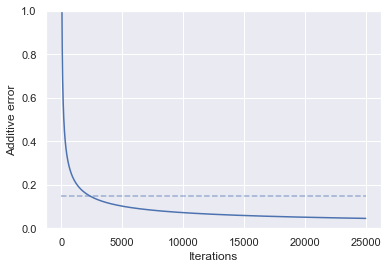

In [112]:
# Visualize how error changes with number of iterations
def get_error(R):
    eps_sq = (np.log(S_len+1) * np.log(1/delta))/R 
    eps = np.sqrt(eps_sq)
    error = eps*n
    return error

Rs = np.arange(0,25000)
plt.plot(Rs, get_error(Rs))
plt.ylim(0,1)
plt.hlines(error_target,0,np.max(Rs), alpha = 0.5,linestyles = 'dashed')
plt.xlabel("Iterations")
plt.ylabel("Additive error")
plt.show()

In the figure above, the additive error is visualised as a function of the number of iterations. As can be seen it meets the target after around 2300 iterarations. 

## Step 2: Optimization algorithm

In [113]:
# Greedy algorithm that uses the monte-carlo sampler

def greedy_algo(cr, k, cp, m, alpha, N, n_items):
    '''
    cr: conversion rates (vector of length 5)
    k: number of montecarlo iterations
    cp: click probabilities (5x5 matrix)
    m: margins (4x5 matrix)
    alpha: the fraction of customers landing on each product page (vector of length 5)
    N: the number of customers (int)
    n_items: the average number of items sold for each product (given the customer buys it initially) (vector of length 5)

    note that all parameters are aggregated (so not for the 3 customer types but an "aggregate" customer type)
    '''
    # initial price configuration 
    price_conf = np.zeros((5),dtype = int)
    
    # Get conversion rates and margins at this price-point
    cr_cur = np.choose(price_conf, cr)
    mar_cur = np.choose(price_conf, m)

    # Estimate the expected reward (the current best) 
    rew_cur = estimate_reward_Montecarlo(k, cp, cr_cur, mar_cur, alpha, N, n_items)
    r = []
    r.append(rew_cur)

    stop = False
    
    while not(stop): 

        # Evaluate raising profit one unit
        rews = np.zeros(5)
        
        for prod in range(0,5):

            if price_conf[prod] < 3:
                
                # price conf to test
                temp = price_conf.copy()
                temp[prod] += 1

                # Get the conversion rates and marings at this price-conf
                cr_cur = np.choose(temp, cr)
                mar_cur = np.choose(temp, m)

                # Monte carlo simulation 
                est =  estimate_reward_Montecarlo(k,cp, cr_cur, mar_cur, alpha, N, n_items)
                rews[prod] = est

        # Check if improvement can be made
        best_ix = np.argmax(rews)
        if rews[best_ix] > rew_cur:

            # raise price and update expected reward
            price_conf[best_ix] += 1 
            rew_cur = rews[best_ix]
            r.append(rew_cur)

        # Otherwise terminate
        else: 
            stop = True

    return price_conf, r

price_conf, r = greedy_algo(cr, k, cp, margins, alpha, N, n_items)


Optimal price configuration:  [1 1 1 0 0]
Expected reward at optimal price conf:  15407.043478260868


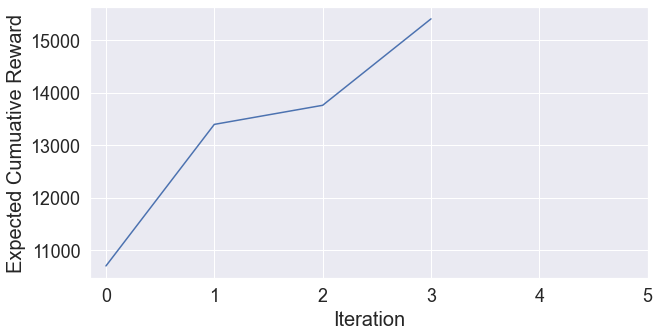

In [114]:
print("Optimal price configuration: ", price_conf)
print("Expected reward at optimal price conf: ", r[-1])

plt.figure(figsize =(10,5))
sns.set_theme()
sns.lineplot(data = pd.DataFrame(r), legend = False)
plt.xlabel("Iteration", fontsize = 20)
plt.ylabel("Expected Cumuative Reward", fontsize = 20)
plt.xticks(range(0,6),fontsize = 18)
plt.yticks(fontsize = 18)
plt.show()

We can now use the greedy algorithm to find obtain an approximation of the optimal reward. This is later used to compute the regret for our learners. 

In [18]:
# Find value to use as the optimal
n_exp = 5
MC_price_conf = []
Exp_rewards = []

for n in range(n_exp):
    price_conf, exp_rew = greedy_algo(cr, k, cp, margins, alpha, N, n_items)
    _, _, rew, _,_, _, _,_, _ = env.round_entire_day(price_conf)
    MC_price_conf.append(price_conf)
    Exp_rewards.append(exp_rew[-1])

opt = np.max(Exp_rewards)
opt

14355.608695652176

### Set-up learning parameters
The following parameters are used to set up the experiments. They decide the time horizon we observe, the number of experiments and the number of iterations we run in the MC simulation. 


In [115]:
# Timehorizon
T = 200
# Number of experiments
n_exp = 3
# Monte Carlo iterations
k = 2300
# SW-UCB window size
windows_size = int(T*0.15)

## Step 3: Optimization with uncertain conversion rates

In [116]:
class learner() :
    
    def __init__(self):
        self.t=0
       
        self.rewards = []
        
    def reset(self):
        self.__init__(self.matrix_cr)
    def act (self):
        pass
    

### Thompson sampling

In [117]:
class TS_Learner (learner):
    
    def __init__ (self,matrix_cr):
        super().__init__()
        self.matrix_cr=matrix_cr
        self.beta_parameters_alpha = np.ones(np.shape(self.matrix_cr))
        self.beta_parameters_beta= np.ones(np.shape(self.matrix_cr))
        
    def pull_arm(self,k,cp,m,alpha,n_items):
        
        beta_matrix = np.random.beta(self.beta_parameters_alpha,self.beta_parameters_beta)
        pull_arm,_= greedy_algo(beta_matrix, k, cp, m, alpha, N, n_items)
        #print("Estimated optimal price conf.: ", pull_arm)
        
        #pulled_arm=beta_matrix.max(axis=0)
        
        return pull_arm
    
    def update (self,pulled_arm,history):
        self.t +=1

        for i in range(len(pulled_arm)):
            buy=sum(history[i])
            
            self.beta_parameters_alpha[pulled_arm[i],i]=self.beta_parameters_alpha[pulled_arm[i],i]+buy
            self.beta_parameters_beta[pulled_arm[i],i]=self.beta_parameters_beta[pulled_arm[i],i]+len(history[i])-buy

In [22]:
import random

ts_ags = TS_Learner(cr)

m = margins

ts_Reward = []
ts_Regret = []

for n in range(n_exp):
    print("Experiment: ", n)
    ts_ags.reset()
    instant_regret = []
    instant_reward = []
        
    for t in range (0,T):
        pulled_arm= ts_ags.pull_arm(k,cp,m,list(alpha),n_items)

        _, _,total_reward, history, _, _, _, _, _ = env.round_entire_day(pulled_arm)

        ts_ags.update(pulled_arm,history)
        
        instant_regret.append(max(0,opt - total_reward)) # max since regret cannot be negative
        instant_reward.append(total_reward)

    cum_regret = np.cumsum(instant_regret)
    cum_reward = np.cumsum(instant_reward)
    ts_Regret.append(cum_regret)
    ts_Reward.append(cum_reward)
    
ts_Regret = np.array(ts_Regret)
ts_Reward = np.array(ts_Reward)

Experiment:  0
Experiment:  1
Experiment:  2


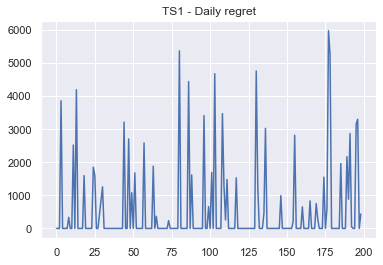

In [23]:
regrets = []
for i in range(len(ts_Regret[0]) - 1, 0, -1):
    regrets.append(ts_Regret[1][i] - ts_Regret[1][i-1])
plt.title('TS1 - Daily regret')
plt.plot(regrets)
plt.show()

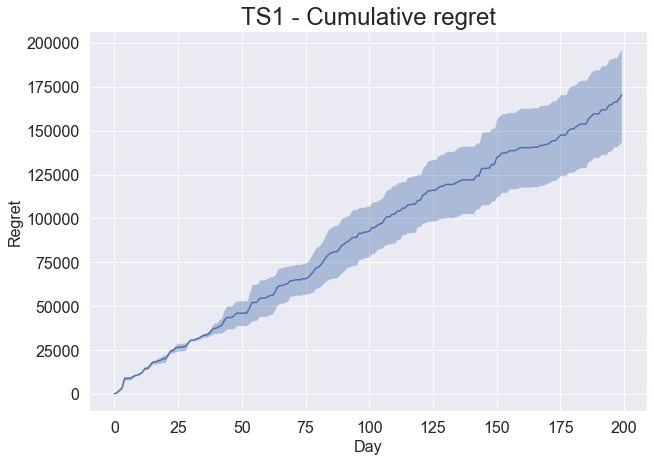

In [170]:
plt.figure(figsize = (10,7))
mean_Regret_ts3 = np.mean(ts_Regret,axis =0)
std_dev_ts3 = np.std(ts_Regret, axis=0)/np.sqrt(n_exp)
plt.plot(mean_Regret_ts3)
plt.fill_between(range(T),mean_Regret_ts3-std_dev_ts3,mean_Regret_ts3+std_dev_ts3,alpha =0.4)
plt.title("TS1 - Cumulative regret",fontsize = 24)
plt.ylabel("Regret", fontsize = 16)
plt.xlabel("Day",fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

In [25]:
with open('result.txt','w') as f: 
    f.write(str(ts_Regret) + '\n') 
    f.write(str(ts_Reward) + '\n') 

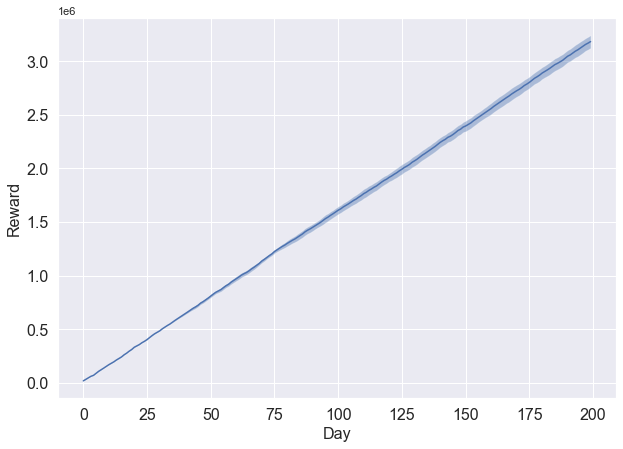

In [171]:
plt.figure(figsize = (10,7))
mean_Reward_ts3 = np.mean(ts_Reward,axis =0)
std_dev_ts3 = np.std(ts_Reward, axis=0)/np.sqrt(n_exp)
plt.plot(mean_Reward_ts3)
plt.fill_between(range(T),mean_Reward_ts3-std_dev_ts3,mean_Reward_ts3+std_dev_ts3,alpha =0.4)
plt.ylabel("Reward", fontsize = 16)
plt.xlabel("Day", fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

#### Calculate Average Regret and Reward 

In [27]:
average_reward = np.mean(mean_Reward_ts3)
average_regret = np.mean(mean_Regret_ts3)

print("Average reward for TS-approach: ", average_reward)
print("Average regret for TS-approach: ", average_regret)

Average reward for TS-approach:  1596390.4966666666
Average regret for TS-approach:  89061.71652173914


### UCB

In [182]:
# Implementation of the learner for the UCB approach
class ucb(learner):
    def __init__(self, matrix_cr, width_bias = 5000):
        super().__init__()
        self.width_bias = width_bias
        self.matrix_cr = matrix_cr
        self.n = np.zeros(np.shape(matrix_cr))

        self.mean_rewards = np.zeros((n_products, n_prices)) #Shape is number of products, number of price levels
        self.width_rewards = np.ones((n_products, n_prices)) * self.width_bias 

    def pull_arm(self, k, cp, m, alpha, n_items): # TODO: Can probably remove these inputs
        # Get arm to pull
        if self.t < n_prices:
            return np.array([self.t for _ in range(n_products)])
        return np.argmax(self.width_rewards + self.mean_rewards, axis = 1)

    def update(self, arm_pulled, history, rew_per_prod):
        self.t += 1

        # Update the mean for the arms in the superarm we have pulled
        for i in range(len(arm_pulled)):
            # Update the mean
            self.mean_rewards[i, arm_pulled[i]] = (self.mean_rewards[i, arm_pulled[i]]*(self.t-1) + rew_per_prod[i]) / self.t
            # perhaps do a weighted mean? Like in part 4 where we take into account that each day has different number of customers

            # Update the counter n
            self.n[arm_pulled[i], i] += 1

            n = self.n[arm_pulled[i], i]

            # Update the width for ALL arms/conversion rates
            self.width_rewards[i, arm_pulled[i]] = self.width_rewards[i, arm_pulled[i]]*np.sqrt(2*np.log(np.maximum(2, self.t))/ n)

In [183]:
ucb_ags = ucb(cr)

m=margins

ucb_Reward3 = []
ucb_Regret3 = []

for n in range(n_exp):
    print("Experiment: ", n)
    ucb_ags.reset()
    instant_regret = []
    instant_reward = []
        
    for t in range (0,T):
        pulled_arm = ucb_ags.pull_arm(k, cp, m, list(alpha), n_items)

        _, _,total_reward, history, _, _, _, _, rew_per_prod = env.round_entire_day(pulled_arm)

        ucb_ags.update(pulled_arm, history, rew_per_prod)
        instant_regret.append(max(0,opt - total_reward))
        instant_reward.append(total_reward)

    cum_regret = np.cumsum(instant_regret)
    cum_reward = np.cumsum(instant_reward)
    ucb_Regret3.append(cum_regret)
    ucb_Reward3.append(cum_reward)
    
ucb_Regret3 = np.array(ucb_Regret3)
ucb_Reward3 = np.array(ucb_Reward3)


Experiment:  0
Experiment:  1
Experiment:  2


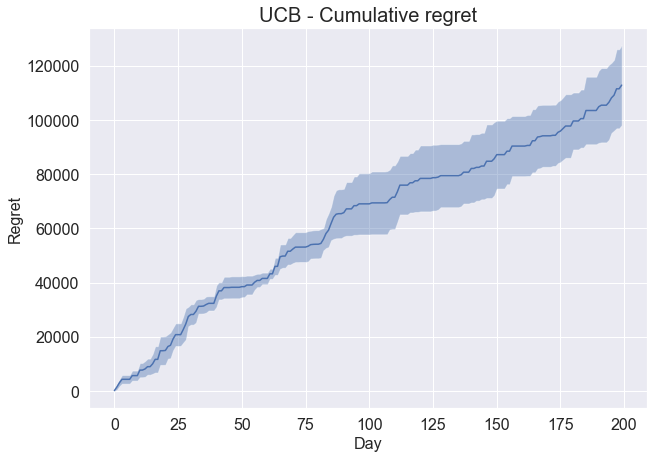

In [184]:
plt.figure(figsize = (10,7))
mean_Regret_ucb3 = np.mean(ucb_Regret3,axis =0)
std_dev_ucb3 = np.std(ucb_Regret3, axis=0)/np.sqrt(n_exp)
plt.plot(mean_Regret_ucb3)
plt.fill_between(range(T),mean_Regret_ucb3-std_dev_ucb3,mean_Regret_ucb3+std_dev_ucb3,alpha = 0.4)
plt.title("UCB - Cumulative regret", fontsize = 20)
plt.ylabel("Regret", fontsize = 16)
plt.xlabel("Day", fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

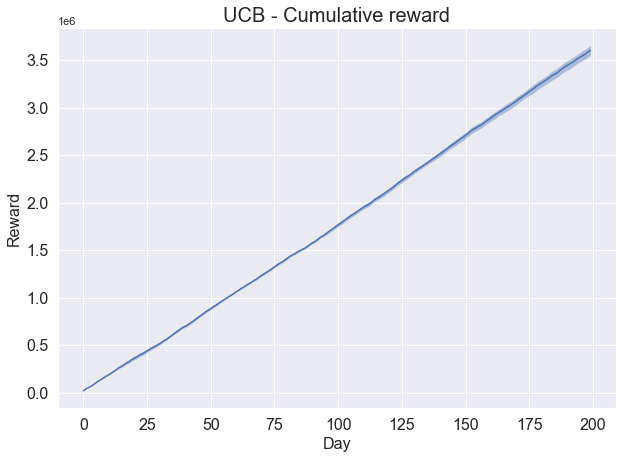

In [185]:
plt.figure(figsize = (10,7))
mean_Reward_ucb3 = np.mean(ucb_Reward3,axis =0)
std_dev_ucb3 = np.std(ucb_Reward3, axis=0)/np.sqrt(n_exp)
plt.plot(mean_Reward_ucb3)
plt.fill_between(range(T),mean_Reward_ucb3-std_dev_ucb3,mean_Reward_ucb3+std_dev_ucb3,alpha =0.4)
plt.title("UCB - Cumulative reward", fontsize = 20)
plt.ylabel("Reward", fontsize = 16)
plt.xlabel("Day", fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

#### Average regret and reward

In [32]:
average_reward = np.mean(mean_Reward_ucb3)
average_regret = np.mean(mean_Regret_ucb3)

print("Average reward for UCB1-approach: ", average_reward)
print("Average regret for UCB1-approach: ", average_regret)

Average reward for UCB1-approach:  1436890.37
Average regret for UCB1-approach:  150826.19710144913


## Step 4: Optimization with uncertain conversion rates, 𝛼-ratios, and number of items sold per product

### Thompson-Sampling

In [120]:
class TS_Learner2 (TS_Learner):
    
    def __init__ (self,matrix_cr):
        super().__init__(matrix_cr)
        
        self.n_items_param = np.ones(np.shape(self.matrix_cr[1]))
        self.alpha_param = np.ones(6) # update 
        self.tot_customer = 0
        self.empiric_mean = 0
        
    def pull_arm(self,k,cp,m,alpha,n_items):
        
        beta_matrix = np.random.beta(self.beta_parameters_alpha,self.beta_parameters_beta)
        
        n_items_estimated = np.random.poisson(self.n_items_param)
        alphas_estimated = np.random.dirichlet(self.alpha_param)
        
        pull_arm,_= greedy_algo(beta_matrix, k, cp, m, alphas_estimated, N, n_items_estimated)
        
        return pull_arm
    
    def update (self,
                pulled_arm,
                cr_dataset, 
                n_items_dataset,
                alpha_dataset,
                Ns): # number of customers (for three types)
        
        self.t +=1
        self.tot_customer += np.sum(Ns)

        ###### Update n_items_param ######     
        actual_customer = np.count_nonzero(n_items_dataset, axis = 0)
        actual_items_buy = np.sum(n_items_dataset, axis = 0)
        self.n_items_param = (actual_items_buy* actual_customer+ self.tot_customer*self.empiric_mean)/(self.tot_customer + actual_customer)
        self.tot_customer += actual_customer
        self.empiric_mean = actual_items_buy
        #self.n_items_param = np.sum(n_items_dataset, axis = 0)/np.count_nonzero(n_items_dataset, axis = 0)
        
        ###### Update alpha params ######
        alpha_dataset = np.average(alpha_dataset,axis = 0, weights = Ns)
        self.alpha_param = self.alpha_param + alpha_dataset
        
        ###### Update conversion rates ######
        for i in range(len(pulled_arm)):
            buy=sum(cr_dataset[i])
            
            self.beta_parameters_alpha[pulled_arm[i],i]=self.beta_parameters_alpha[pulled_arm[i],i]+buy
            self.beta_parameters_beta[pulled_arm[i],i]=self.beta_parameters_beta[pulled_arm[i],i]+len(cr_dataset[i])-buy
            
            

In [34]:

ts_ags = TS_Learner2(cr)

m=margins

ts_rewards_per_experiment=[]

ts4_Reward = []
ts4_Regret = []

for n in range(n_exp):
    print("Experiment: ", n)
    ts_ags.reset()
    instant_regret = []
    instant_reward = []
        
    for t in range (0,T):
        pulled_arm = ts_ags.pull_arm(k,cp,m,list(alpha),n_items)
        _, _, total_reward, cr_dataset, n_items_dataset, alphas_dataset, Ns, _, _ = env.round_entire_day(pulled_arm)

        ts_ags.update(pulled_arm,cr_dataset, n_items_dataset, alphas_dataset, Ns)
        instant_regret.append(max(0,opt - total_reward)) # max since regret cannot be negative
        instant_reward.append(total_reward)

    cum_regret = np.cumsum(instant_regret)
    cum_reward = np.cumsum(instant_reward)
    ts4_Regret.append(cum_regret)
    ts4_Reward.append(cum_reward)
    
ts4_Regret = np.array(ts4_Regret)
ts4_Reward = np.array(ts4_Reward)




Experiment:  0
Experiment:  1
Experiment:  2


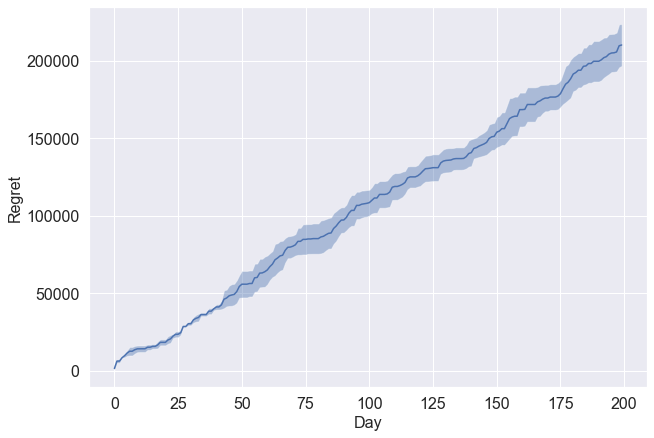

In [186]:
plt.figure(figsize = (10,7))
mean_Regret_ts4 = np.mean(ts4_Regret,axis =0)
std_dev_ts4 = np.std(ts4_Regret, axis=0)/np.sqrt(n_exp)
plt.plot(mean_Regret_ts4)
plt.fill_between(range(T),mean_Regret_ts4-std_dev_ts4,mean_Regret_ts4+std_dev_ts4,alpha =0.4)
plt.ylabel("Regret", fontsize = 16)
plt.xlabel("Day", fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

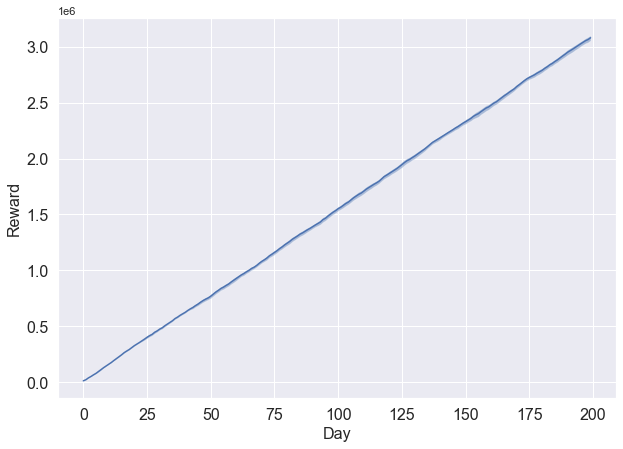

In [187]:
plt.figure(figsize = (10,7))
mean_Reward_ts4 = np.mean(ts4_Reward,axis =0)
std_dev_ts4 = np.std(ts4_Reward, axis=0)/np.sqrt(n_exp)
plt.plot(mean_Reward_ts4)
plt.fill_between(range(T),mean_Reward_ts4-std_dev_ts4,mean_Reward_ts4+std_dev_ts4,alpha =0.4)
plt.ylabel("Reward", fontsize = 16)
plt.xlabel("Day", fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

#### Average regret and reward

In [37]:
average_reward = np.mean(mean_Reward_ts4)
average_regret = np.mean(mean_Regret_ts4)

print("Average reward for TS-approach: ", average_reward)
print("Average regret for TS-approach: ", average_regret)

Average reward for TS-approach:  1546730.195
Average regret for TS-approach:  105259.4742753623


### UCB
As the UCB approach used in step 3 optimizes with respect to the reward and only the reward for each price level for each product, no adaptions need to be made to the learner when the alpha-ratios and number of items sold per product is no longer known apriori. Consequentially, the performance of the algorithm is also expected to be the same in the new setting. 

## Step 5: Optimization with uncertain graph weights

### Thompson-Sampling

In [121]:
class TS_Learner5 (learner):
    
    def __init__ (self,matrix_cp):
        super().__init__()
        self.matrix_cp = matrix_cp
        self.beta_parameters_alpha = np.ones(np.shape(self.matrix_cp))
        self.beta_parameters_beta= np.ones(np.shape(self.matrix_cp))
        self.beta_matrix=np.random.beta(self.beta_parameters_alpha,self.beta_parameters_beta)
        
    def reset(self):
        self.__init__(self.matrix_cp)
        #given the dataset episodes_dataset, it is the output
        #of the function round_entire_day of the class Enviroment.
        #and given the numbe of product the fuction return
        #a matrix that represent the graph matrix
    
    def graph_matrix_comp(n_prod, dataset):
        #initialize the matrix with zeros
        matrix = np.zeros([n_prod,n_prod])
        list_customer = np.zeros(n_prod)
        #the length represent the number of customer that land on the webpage
        for j in range(len(dataset)): 
            #which is the product that the customer bought
            after_buy = dataset[j].tolist()
            # if the first element of the list is a flot
            # this means that customer didn't buy any product
            if  type(after_buy[0]) != float :
                # which is the product that the customer bbuy
                row = after_buy[0].index(1)
                for i in range(len(after_buy)-2):
                        col = after_buy[i+1].index(1)
                        matrix[row][col] += 1
                        
        cust_matrix = []
        for el in range(n_prod):
            cust_matrix.append([list_customer[el] for _ in range (5) ])
        
        return matrix, cust_matrix


    def pull_arm(self,k,cr,m,alpha,n_items):
        
        beta_matrix = np.random.beta(self.beta_parameters_alpha, self.beta_parameters_beta)
        pull_arm,_ = greedy_algo(cr, k, beta_matrix, m, alpha, N, n_items)
        
        return pull_arm
    
    def update(self,n_prod,episodes_dataset):
        self.t +=1
        
        alpha, beta = graph_matrix_comp(n_prod,episodes_dataset)
        
        self.beta_parameters_alpha = (self.beta_parameters_alpha+alpha)/self.t 
        self.beta_parameters_beta = (self.beta_parameters_beta+beta-alpha)/self.t 
        # Correct zero elements to ones
                # Correct zero elements to ones
        self.beta_parameters_beta[self.beta_parameters_beta < 1] = 1
        self.beta_parameters_alpha[self.beta_parameters_alpha < 1] = 1

In [122]:
def graph_matrix_comp(n_prod, dataset):
    #initialize the matrix with zeros
    matrix = np.zeros([n_prod,n_prod])
    list_customer = np.zeros(n_prod)
    #the length represent the number of customer that land on the webpage
    for j in range(len(dataset)): 
        #which is the product that the customer bought
        after_buy = dataset[j].tolist()
        # if the first element of the list is a flot
        # this means that customer didn't buy any product
        if  type(after_buy[0]) != float :
            # which is the product that the customer bbuy
            row = after_buy[0].index(1)
            for i in range(len(after_buy)-2):
                    col = after_buy[i+1].index(1)
                    matrix[row][col] += 1

    cust_matrix = []
    for el in range(n_prod):
        cust_matrix.append([list_customer[el] for _ in range (5) ])

    return matrix, cust_matrix

In [40]:
ts_ags = TS_Learner5(cp)

ts5_Reward = []
ts5_Regret = []
n_prod = 5

for n in range(0,n_exp):
    print("Experiment: ", n)
    ts_ags.reset()
    instant_regret = []
    instant_reward = []
        
    for t in range(0,T):
        pulled_arm = ts_ags.pull_arm(k,cr,m,list(alpha),n_items)
        
        _, episodes_dataset, total_reward, cr_dataset, n_items_dataset, alphas_dataset, Ns, _, _ = env.round_entire_day(pulled_arm)

        ts_ags.update(n_prod,episodes_dataset)
        
        instant_regret.append(max(0,opt - total_reward)) # max since regret cannot be negative
        instant_reward.append(total_reward)

    cum_regret = np.cumsum(instant_regret)
    cum_reward = np.cumsum(instant_reward)
    ts5_Regret.append(cum_regret)
    ts5_Reward.append(cum_reward)
    
ts5_Regret = np.array(ts5_Regret)
ts5_Reward = np.array(ts5_Reward)

Experiment:  0
Experiment:  1
Experiment:  2


In [41]:
with open('result.txt','w') as f: 
    f.write(str(ts_Regret) + '\n') 
    f.write(str(ts_Reward) + '\n')

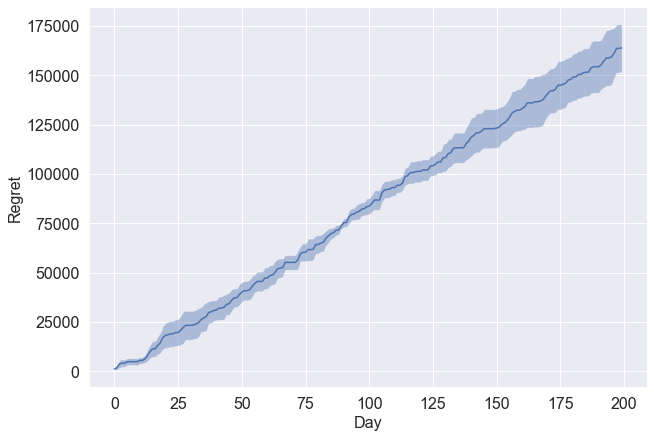

In [188]:
plt.figure(figsize = (10,7))
mean_Regret_ts5 = np.mean(ts5_Regret,axis =0)
std_dev_ts5 = np.std(ts5_Regret, axis=0)/np.sqrt(n_exp)
plt.plot(mean_Regret_ts5)
plt.fill_between(range(T),mean_Regret_ts5-std_dev_ts5,mean_Regret_ts5+std_dev_ts5,alpha =0.4)
plt.ylabel("Regret", fontsize = 16)
plt.xlabel("Day", fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

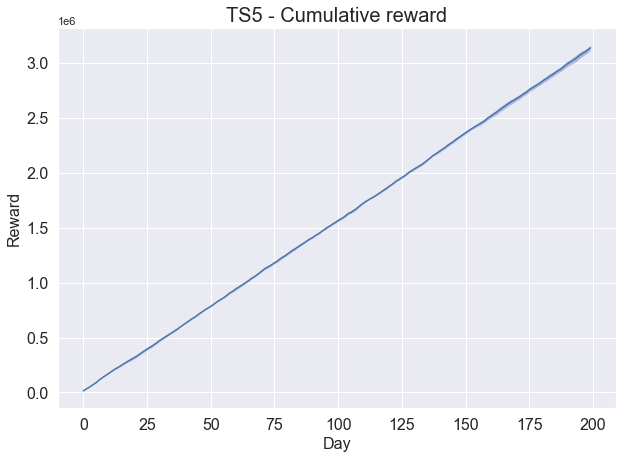

In [189]:
plt.figure(figsize = (10,7))
mean_Reward_ts5 = np.mean(ts5_Reward,axis =0)
std_dev_ts5 = np.std(ts5_Reward, axis=0)/np.sqrt(n_exp)
plt.plot(mean_Reward_ts5)
plt.fill_between(range(T),mean_Reward_ts5 - std_dev_ts5,mean_Reward_ts5 + std_dev_ts5,alpha = 0.4)
plt.title("TS5 - Cumulative reward", fontsize = 20)
plt.ylabel("Reward",fontsize = 16)
plt.xlabel("Day",fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

#### Average regret and reward

In [44]:
average_reward = np.mean(mean_Reward_ts5)
average_regret = np.mean(mean_Regret_ts5)

print("Average reward for TS5-approach: ", average_reward)
print("Average regret for TS5-approach: ", average_regret)

Average reward for TS5-approach:  1565903.0883333334
Average regret for TS5-approach:  82177.30934782613


### UCB
The same logic applies here as the one presented in step 4 with regards to the performance of the UCB1-learner in a setting where the graph weights are also masked for it.

## Step 6: Non-stationary demand curve

### Sliding Window UCB
To handle a dynamic environment, a sliding window approach has been adopted for the UCB learner, which works by limiting the dataset in which the learner calculates its reward estimates on to a given size $\tau$. 

In [123]:
# Sliding window UCB learner
class SW_UCB(ucb):
    def __init__(self, matrix_cr, window_size):
        super().__init__(matrix_cr)
        self.window_size = window_size  # tau

        # Reward and simulation data
        self.data = []
        self.current_data = None

        # Arms pulled history
        self.pulled_arms = []
        self.current_pulled_arms = None

    def pull_arm(self, k, cp, m, alpha, n_items):
        return super().pull_arm(k, cp, m, alpha, n_items)

    def reset(self):
        self.__init__(self.matrix_cr, self.window_size)

    def update(self, arm_pulled, history, rew_per_prod):
        self.t += 1

        # Recording pulled arms
        self.pulled_arms.append(arm_pulled)

        # Recording rewards for each product given price level
        current_obs = np.zeros((n_products, n_prices))
        for i in range(len(arm_pulled)):
            current_obs[i, arm_pulled[i]] = rew_per_prod[i]
        self.data.append(current_obs)

        # Fetching the data for the current window
        self.current_data = np.array(self.data[
            np.maximum(0, len(self.data) - self.window_size) :
        ])
        self.current_pulled_arms = np.array(self.pulled_arms[
            np.maximum(0, len(self.data) - self.window_size) :
        ])


        # Update the mean for the arms in the superarm we have pulled
        for i in range(len(arm_pulled)):
            # Update the mean
            temp = self.current_data[:, i, arm_pulled[i]]
            if len(temp[np.nonzero(temp)]):
                self.mean_rewards[i, arm_pulled[i]] = np.average(temp[np.nonzero(temp)])

        # Update the width for rewards in the superarm we have pulled
        for i in range(len(arm_pulled)):
            # Count number of times arm has been pulled in current window
            n = (
                np.sum(np.array(self.current_pulled_arms)[:, i] == arm_pulled[i]) - 1
            )  # -1 to account for the current pull

            # Update width for the values of the current window
            self.width_rewards[i, arm_pulled[i]] = self.width_rewards[
                i, arm_pulled[i]
            ] * np.sqrt(np.log(np.maximum(self.t, 2)) / np.maximum(1, n))


### Change Detection UCB

In [124]:
class ChangeDetector:
    def __init__(self, M, eps, h):
        self.M = M #number of tuning samples
        self.eps = eps
        self.h = h #threshold
        
        self.t = 0 #time
        self.reference = 0
        self.g_plus = 0
        self.g_minus = 0
    
    def detect(self, reward, i): #we have to understand what is sample
        self.t += 1
        
        #for the first M samples we tune the reference value of the detector
        if self.t <= self.M:
            self.reference += reward/self.M
                
            return 0
        
        #from M+1th sample we can detect some changes
        else: 
            s_plus = (reward - self.reference) - self.eps
            s_minus = -(reward - self.reference) - self.eps

            self.g_minus = max(0, self.g_minus + s_minus)
            self.g_plus = max(0, self.g_plus + s_plus)

            #we return 1 only if the new sample is greater than the reference by a value greater than the threshold
            return self.g_plus > self.h or self.g_minus > self.h

    def reset(self):
        self.t = 0
        self.reference = 0
        self.g_minus = 0
        self.g_plus = 0

In [125]:
class CD_UCB(ucb):

    def __init__(self, matrix_cr, M, eps, h):
        super().__init__(matrix_cr)

        self.change_detector = [ChangeDetector(M,eps,h) for _ in self.mean_rewards.reshape(-1)]
        
        self.detections = [[] for _ in self.mean_rewards.reshape(-1)]
        self.valid_rewards = [[] for _ in self.mean_rewards.reshape(-1)]
    
    def pull_arm(self, k, cp, m, alpha, n_items):
        return super().pull_arm(k, cp, m, alpha, n_items)

    def reset(self):
        self.__init__(self.matrix_cr, 50, 100, 10000)

    def update(self, arm_pulled, history, rew_per_prod):
        self.t += 1

        for i in range(len(arm_pulled)):

            arm = np.ravel_multi_index([i, arm_pulled[i]], np.shape(self.mean_rewards))
        
            if self.change_detector[arm].detect(rew_per_prod[i], i):
                self.detections[arm].append(self.t)
                self.valid_rewards[arm] = []
                self.change_detector[arm].reset

            self.valid_rewards[arm].append(rew_per_prod[i])

            self.mean_rewards[i, arm_pulled[i]] = np.mean(self.valid_rewards[arm])

            if len(self.valid_rewards[arm]) > 0:
                n=len(self.valid_rewards[arm])
                self.width_rewards[i, arm_pulled[i]] = min(np.sqrt(2*np.log(self.t)/n),1)
            
            else:
                self.width_rewards[i, arm_pulled[i]] = 1 * 10000 #TODO: Check this


### Implementation of non-stationary environment

In [126]:
# extend environment to have an abrupt change
class NonstatEnvironment(Environment):

    def __init__(self,
                env,
                conversion_rates_mult,
                phase_len,
                ):
        '''
        Takes as input

        1. conversion_rates_mult - matrix similar to conversion rates in original environment 
           with an extra dimension containing the cr for each phase of the nonstationary environment
        
        2. phase_len - Length of each phase for the conversion rates (e.g. phase_len = 30 if the length of the phases should be for 30 days)
        '''
        super().__init__(
            conversion_rates=conversion_rates_mult[0],
            margins = env.margins,
            click_probabilities = env.click_probabilities,
            no_items_bought= env.no_items_bought,
            alpha_params=env.alpha_params,
            N_params=env.N_params,
            )
        self.conversion_rates_mult = conversion_rates_mult 
        self.t = 0
        self.phase_len = phase_len
    
    def dynamic_round_entire_day(self, arms): 
        # Updates self.conversion_rates if it has entered a new phase, and increments the day by one
        self.conversion_rates = self.conversion_rates_mult[(self.t // self.phase_len) % len(self.conversion_rates_mult)]
        self.t += 1
        
        # return the regular function of the environment
        return self.round_entire_day(arms)



In [127]:
conversion_rates_p1 = np.array([conversion_rates_1, conversion_rates_2, conversion_rates_3])
conversion_rates_p2 = np.array([conversion_rates_3, conversion_rates_1, conversion_rates_2])
conversion_rates_mult = np.array([conversion_rates_p1, conversion_rates_p2])

In [128]:
phase_len = T/2
non_stat_env = NonstatEnvironment(env, conversion_rates_mult, int(phase_len))

#### Test SW-UCB algorithm on stationary and non-stationary environment

In [129]:
m=margins
ucb6_Reward = []
ucb6_Regret = []
SW_UCB_ags = SW_UCB(cr,windows_size)

for n in range(n_exp):
    print("Experiment: ", n)
    SW_UCB_ags.reset()
    instant_regret = []
    instant_reward = []
        
    for t in range (0,T):
        
        pulled_arm = SW_UCB_ags.pull_arm(k, cp, m, list(alpha), n_items)

        _, _,total_reward, history, _, _, _, _, rew_per_prod = env.round_entire_day(pulled_arm)

        SW_UCB_ags.update(pulled_arm, history, rew_per_prod)
        instant_regret.append(max(0,opt - total_reward))
        instant_reward.append(total_reward)

    cum_regret = np.cumsum(instant_regret)
    cum_reward = np.cumsum(instant_reward)
    ucb6_Regret.append(cum_regret)
    ucb6_Reward.append(cum_reward)
    
ucb6_Regret = np.array(ucb6_Regret)
ucb6_Reward = np.array(ucb6_Reward)

Experiment:  0
Experiment:  1
Experiment:  2


In [130]:
m=margins
ucb_Reward_nonstat = []
ucb_Regret_nonstat = []

SW_UCB_ags_nonstat = SW_UCB(cr,windows_size)

for n in range(n_exp):
    print("Experiment: ", n)
    SW_UCB_ags.reset()
    instant_regret = []
    instant_reward = []
        
    for t in range (0,T):
        pulled_arm = SW_UCB_ags_nonstat.pull_arm(k, cp, m, list(alpha), n_items)

        _, _,total_reward, history, _, _, _, _, rew_per_prod = non_stat_env.dynamic_round_entire_day(pulled_arm)

        SW_UCB_ags_nonstat.update(pulled_arm, history, rew_per_prod)
        instant_regret.append(max(0,opt - total_reward))
        instant_reward.append(total_reward)

    cum_regret = np.cumsum(instant_regret)
    cum_reward = np.cumsum(instant_reward)
    ucb_Regret_nonstat.append(cum_regret)
    ucb_Reward_nonstat.append(cum_reward)
    
ucb_Regret_nonstat = np.array(ucb_Regret_nonstat)
ucb_Reward_nonstat = np.array(ucb_Reward_nonstat)

Experiment:  0
Experiment:  1
Experiment:  2


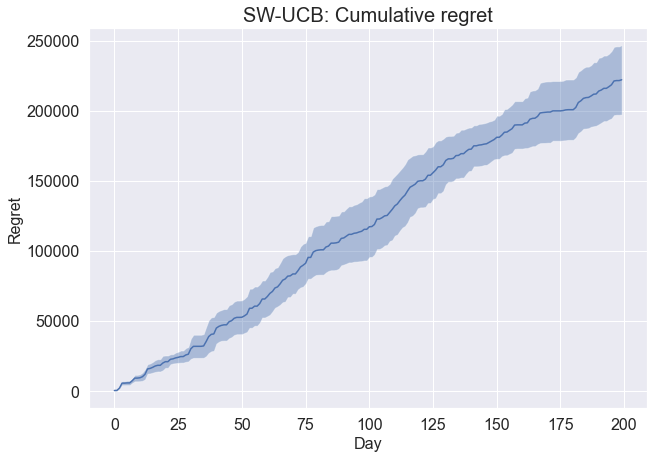

In [190]:
plt.figure(figsize = (10,7))
mean_Regret_ucb6 = np.mean(ucb6_Regret,axis =0)
std_dev_ucb6 = np.std(ucb6_Regret, axis=0)/np.sqrt(n_exp)
plt.plot(mean_Regret_ucb6)
plt.fill_between(range(T),mean_Regret_ucb6-std_dev_ucb6,mean_Regret_ucb6+std_dev_ucb6,alpha = 0.4)
plt.title("SW-UCB: Cumulative regret", fontsize = 20)
plt.ylabel("Regret", fontsize = 16)
plt.xlabel("Day", fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

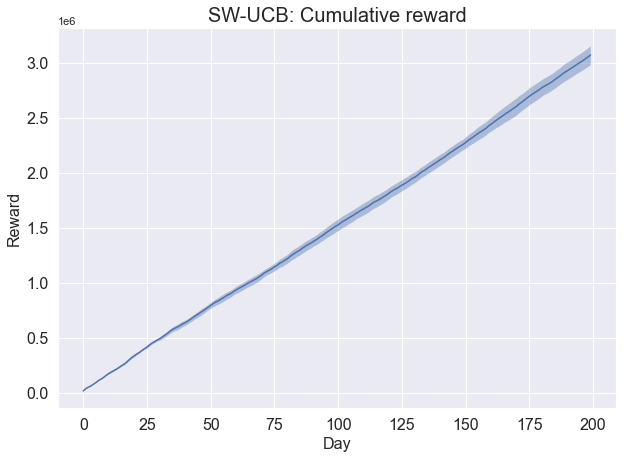

In [191]:
mean_Reward_ucb6 = np.mean(ucb6_Reward,axis =0)
std_dev_ucb6 = np.std(ucb6_Reward, axis=0)/np.sqrt(n_exp)

plt.figure(figsize = (10,7))
plt.plot(mean_Reward_ucb6)
plt.fill_between(range(T),mean_Reward_ucb6-std_dev_ucb6,mean_Reward_ucb6+std_dev_ucb6,alpha = 0.4)
plt.title("SW-UCB: Cumulative reward", fontsize = 20)
plt.ylabel("Reward", fontsize = 16)
plt.xlabel("Day", fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

#### Average regret and reward

In [133]:
average_reward = np.mean(mean_Reward_ucb6)
average_regret = np.mean(mean_Regret_ucb6)

print("Average reward for SW-UCB: ", average_reward)
print("Average regret for SW-UCB: ", average_regret)

Average reward for SW-UCB:  1526388.2733333332
Average regret for SW-UCB:  117095.01434782604


### Test CD-UCB algorithm on stationary and non-stationary environment

In [134]:
m=margins
cd_ucb_Reward = []
cd_ucb_Regret = []

cumsum_UCB_ags = CD_UCB(conversion_rates, 50, 100, 10000)

for n in range(n_exp):
    print("Experiment: ", n)
    cumsum_UCB_ags.reset()
    instant_regret = []
    instant_reward = []
        
    for t in range (0,T):
        pulled_arm = cumsum_UCB_ags.pull_arm(k, cp, m, list(alpha), n_items)
        _, _,total_reward, history, _, _, _, _, rew_per_prod = env.round_entire_day(pulled_arm)

        cumsum_UCB_ags.update(pulled_arm, history, rew_per_prod)
        instant_regret.append(max(0,opt - total_reward))
        instant_reward.append(total_reward)

    cum_regret = np.cumsum(instant_regret)
    cum_reward = np.cumsum(instant_reward)
    cd_ucb_Regret.append(cum_regret)
    cd_ucb_Reward.append(cum_reward)
    
cd_ucb_Regret = np.array(cd_ucb_Regret)
cd_ucb_Reward = np.array(cd_ucb_Reward)

Experiment:  0
Experiment:  1
Experiment:  2


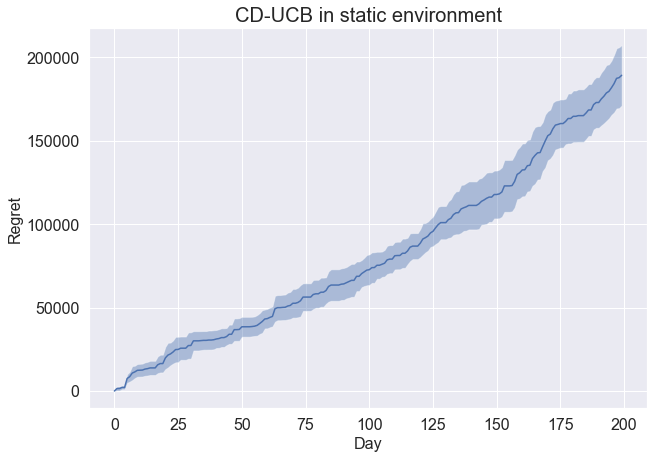

In [211]:
cd_mean_Regret = np.mean(cd_ucb_Regret,axis =0)
cd_std_dev = np.std(cd_ucb_Regret, axis=0)/np.sqrt(n_exp)
plt.figure(figsize = (10,7))
plt.plot(cd_mean_Regret)
plt.fill_between(range(T),cd_mean_Regret-cd_std_dev,cd_mean_Regret+cd_std_dev,alpha = 0.4)
plt.title("CD-UCB in static environment", fontsize = 20)
plt.ylabel("Regret", fontsize = 16)
plt.xlabel("Day", fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

In [136]:
m=margins
cd_ucb_Reward_nonstat = []
cd_ucb_Regret_nonstat = []

cumsum_UCB_ags_nonstat = CD_UCB(cr, 50, 100, 10000)

for n in range(n_exp):
    print("Experiment: ", n)
    cumsum_UCB_ags_nonstat.reset()
    instant_regret = []
    instant_reward = []
        
    for t in range (0,T):
        pulled_arm = cumsum_UCB_ags_nonstat.pull_arm(k, cp, m, list(alpha), n_items)

        _, _,total_reward, history, _, _, _, _, rew_per_prod = non_stat_env.dynamic_round_entire_day(pulled_arm)
        
        cumsum_UCB_ags_nonstat.update(pulled_arm, history, rew_per_prod)
        instant_regret.append(max(0,opt - total_reward))
        instant_reward.append(reward)

    cum_regret = np.cumsum(instant_regret)
    cum_reward = np.cumsum(instant_reward)
    cd_ucb_Regret_nonstat.append(cum_regret)
    cd_ucb_Reward_nonstat.append(cum_reward)
    
cd_ucb_Regret_nonstat = np.array(cd_ucb_Regret_nonstat)
cd_ucb_Reward_nonstat = np.array(cd_ucb_Reward_nonstat)

Experiment:  0
Experiment:  1
Experiment:  2


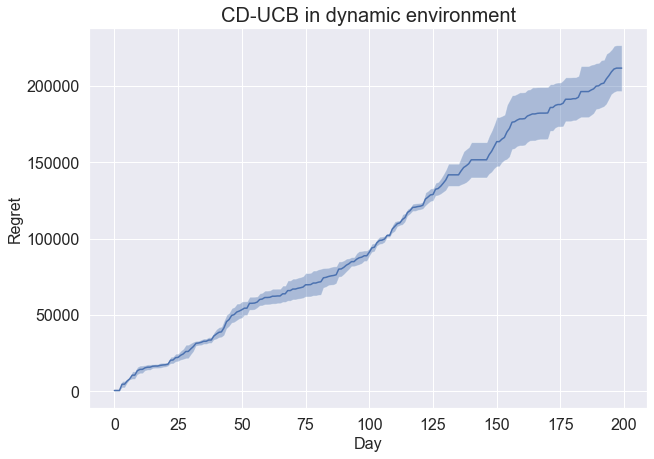

In [192]:
cd_mean_Regret_ns = np.mean(cd_ucb_Regret_nonstat,axis =0)
cd_std_dev_ns = np.std(cd_ucb_Regret_nonstat, axis=0)/np.sqrt(n_exp)
plt.figure(figsize = (10,7))
plt.plot(cd_mean_Regret_ns)
plt.fill_between(range(T),cd_mean_Regret_ns-cd_std_dev_ns,cd_mean_Regret_ns+cd_std_dev_ns,alpha = 0.4)
plt.title("CD-UCB in dynamic environment", fontsize = 20)
plt.ylabel("Regret", fontsize = 16)
plt.xlabel("Day", fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

## Step 7: Context generation

In [212]:
#the envviroment is the same as before,the only difference is that the round_entire_day 
#function also takes as input a list containing the binary features of the customers
#customer can simulate.so we could simulate the customers separately within the day

class Environment7():

    def __init__(self, 
                conversion_rates, 
                margins, 
                click_probabilities, 
                no_items_bought,
                alpha_params,
                N_params
                ):
        '''
        Takes as input
        1. Conversion rates for each price-level (3-dim matrix)
        
        2. Margins for the products at the different price-levels 
        
        3. Probabilities of the user visiting other products (one graph for each customer type)
        
        4. The expected number of items a customer will buy for each customer type and product type 
           (used as input for the Poisson process)
        
        5. Alpha-values representing the expected fractions of the customers landing on the product pages (a1-a5) and competitor pages a0
        
        6. The expected daily number of potential customers (3 different types) 
           This is used to draw the daily number of customers each day 
        '''
        
        self.conversion_rates = conversion_rates 
        self.margins = margins 
        self.click_probabilities = click_probabilities
        self.no_items_bought = no_items_bought
        self.alpha_params = alpha_params
        self.N_params = N_params
            
    # model interaction with learner
    # round takes as input the chosen arms/prices and returns a stochastic reward
    def round(self, arms, init_product, features):
        '''
        Arms are the indices of the chosen price-levels for each product, e.g. [0,1,1,2,4] 
        Init_product is the product the customer initially lands on 
        Features are the binary features of the customer e.g. [0,0] or [0,1]
        '''
        
        # Determine the class of the user based on the features
        # NB I have just chosen some random customer types 
        
        if features[0] == 0 & features[1] == 0:
            context = 0
        elif features[0] == 1 & features[1] == 1:
            context = 1
        else: context = 2
        
        # check if customer buys the primary product, if yes, trigger episode 
        buy = np.random.binomial(n=1,p = self.conversion_rates[context, arms[init_product], init_product])
        # Rewards per product for current day
        rew_per_prod = np.array([0 for _ in range(5)], dtype=float)
        
        ################ the customer buys the initial primary product ################
        if buy: 
            # get conversion rates as a vector (for these prices and this context)
            cr = np.zeros(5)
            for i,j in zip(arms, range(5)):
                cr[j] = self.conversion_rates[context, i,j]
            click_probs = self.click_probabilities[context,:,:]
            
            # let the customer move along the graph (stochastically)
            history, x = simulate_episode(init_product, click_probs, cr)

            # draw the number of items the customer buys
            n_items_sold = np.zeros(5)
            for array in history: 
                # the number of items sold follows a Poisson distribution 
                # add and subtract 1 to make sure it is not zero! 
                lambdas = self.no_items_bought[context,:]-np.ones(5)
                n_items_sold += array*(np.random.poisson(lambdas)+np.ones(5))
            
            # compute reward
            reward = 0
            for i in range(5):
                reward += n_items_sold[i]*self.margins[arms[i], i]
                rew_per_prod[i] += n_items_sold[i]*self.margins[arms[i],i]
        ################ does NOT buy the initial primary product ################
        else: 
            x = [[] for _ in range(5)]
            x[init_product].append(0)
            history = np.zeros(5)
            n_items_sold = np.zeros(5)
            reward = 0
        
        return history, n_items_sold, reward, x,rew_per_prod
    
    def round_entire_day(self, arms,type_customer):
        '''
        collects observations for a whole day - uses function defined above 

        Takes as input: 
        arms: The chosen price-levels e.g. [0,1,1,2,4]
        
        '''
        
        # store whether or not we make a conversion
        X = [[] for _ in range(5)]
        
        # Draw how many customers we have this day 
        Ns = np.random.poisson(self.N_params)  # type 1, 2,  3

        # Draw how many of each type lands on each product page 
        #print("Alphas: ", self.alpha_params)
        alpha_sampled = [np.random.dirichlet(self.alpha_params[0,:]),    # type 1
                        np.random.dirichlet(self.alpha_params[1,:]),    # type 2
                        np.random.dirichlet(self.alpha_params[2,:])]    # type 3

        # Get observations for each type
        context_experiments = []
        episodes_dataset = []
        n_items_dataset = []
        types = type_customer
        
        # Record of reward per product for current day
        sum_rew_per_prod = np.array([0 for _ in range(5)], dtype=float)
        
        # Allocate space for saving the dataset for each feature
        features_dataset = dict()
        features_dataset[(0,0)] = {"n_items":[], "X":[[] for _ in range(5)],"N_customers":0, "reward":0,'alpha_sampled':0,'sum_rew_per_prod':0}
        features_dataset[(0,1)] = {"n_items":[], "X":[[] for _ in range(5)],"N_customers":0,"reward":0,'alpha_sampled':0,'sum_rew_per_prod':0}
        features_dataset[(1,0)] = {"n_items":[], "X":[[] for _ in range(5)],"N_customers":0,"reward":0,'alpha_sampled':0,'sum_rew_per_prod':0}
        features_dataset[(1,1)] = {"n_items":[], "X":[[] for _ in range(5)],"N_customers":0,"reward":0,'alpha_sampled':0,'sum_rew_per_prod':0}
        
        for f, N, a in zip(types, Ns, alpha_sampled):
            sum_result = [np.zeros(5), 0]
            
            for i in range(np.abs(N)): # Sampling based on distribution so edge-case can cause draws to be negative
                # Draws a landing-product based on distribution of alphas
                landing_product = np.random.choice(np.arange(6), 1, p=a)[0]

                # Checks if product is one of our products
                if(landing_product < 5):

                    # The learner needs to observe the set of features for each observation (so it can learn it later)
                    # therefore the the featurespace is defined below for each customer-type

                   
                    # Runs simulation for given customer
                    round_his, round_items, round_rew, x,round_rew_per_prod = self.round(arms, landing_product, f)
                    
                    # Stores result for individual customer 
                    sum_result[0] += round_items
                    sum_result[1] += round_rew
                    episodes_dataset.append(round_his)
                    X = [X[i]+x[i] for i in range(5)]
                    n_items_dataset.append(round_items)
                    sum_rew_per_prod += round_rew_per_prod
                    
                    
                    # Store dataset for each featurecombination
                    features_dataset[f]["X"] = [features_dataset[f]["X"][i]+x[i] for i in range(5)]
                    features_dataset[f]["n_items"].append(round_items)
                    features_dataset[f]["N_customers"] += 1 
                    features_dataset[f]["reward"]+=round_rew
                    features_dataset[f]['alpha_sampled']=a
                features_dataset[f]['sum_rew_per_prod']=sum_rew_per_prod
                   # features_dataset[f]["alpha_sampled"]+=alpha_sampled
            # Stores results from simulation for each user class
            context_experiments.append(sum_result)

        # return dataset and total reward for that day 
        total_reward = np.sum([l[1] for l in context_experiments])
        data = context_experiments 
            
        return data, episodes_dataset, total_reward, X, n_items_dataset, alpha_sampled, Ns, features_dataset,sum_rew_per_prod

### Customer class

In [213]:

#the customer class takes the values observed during each day and saves and updates them



class customer():
    def __init__(self,cr,i,j):
        #store the cr matrix for each type of customer
        self.database_cr=np.zeros(cr.shape)
        #for each type of customer save how many type of product the customer have bought
        self.n_customer=[[0] for _ in range(5)]
        #the beta parameters of cr per each customer
        self.beta_parameters_alpha = np.ones(np.shape(self.database_cr))
        self.beta_parameters_beta= np.ones(np.shape(self.database_cr))
        #save the binary feature each customer must have an unique type of customer
        #the type of customer can be (0,0) , (1,0) , (0,1) , (1,1)
        self.type_of_customer=(i,j)
        self.empiric_mean = 0
                ###for ucb###
        #the bias for the ucb
        self.width_bias=5000
        self.mean_rewards = np.zeros((5, 4)) #Shape is number of products, number of price levels
        self.width_rewards = np.ones((5, 4)) * self.width_bias 
        #the alpha parameter per each customer
        self.alpha_param = np.ones(6)/6 # update 
        self.n_items_param = np.ones(np.shape(self.database_cr[1]))
        #the total number of customer that buy at least one product
        self.tot_customer = 1
        #total number of customer that lend on the webpage or lend in the competitor's webpage
        self.customer_landing=0
        #time
        self.t=0
        #the same of ucb 
        self.n=np.zeros(np.shape(cr))
        
    def update(self,features_dataset,arm_pulled,Ns):
        self.t+=1
                # Determine the class of the user based on the features
        # NB I have just chosen some random customer types 
        if self.type_of_customer[0] == 0 & self.type_of_customer[1] == 0:
            context = 0
        elif self.type_of_customer[0] == 1 & self.type_of_customer[1] == 1:
            context = 1
        else: context = 2
        
        Ns=Ns
        
        
        
        #number of customer that buy at least one prod
        actual_customer = np.count_nonzero(features_dataset[self.type_of_customer]['n_items'], axis = 0)
        #average number of products that each customer has bought
        actual_items_buy =np.mean(features_dataset[self.type_of_customer]['n_items'], axis = 0)
        
        #if a customer don't buy a product don't update 
        #else update the average of product bought by each customer
        try :
            if (np.isnan(actual_items_buy)):
                     actual_items_buy=np.zeros(5)
        except:
            actual_items_buy=actual_items_buy
        self.n_items_param = (actual_items_buy* (self.t-1)+ actual_items_buy)/(self.t)

        
        
        try:
            self.tot_customer += sum(actual_customer)
            self.customer_landing +=len(features_dataset[self.type_of_customer]["X"])
        except:
            self.customer_landing += 0
            self.tot_customer += 0

        
                ###### Update alpha params ######
        alpha_dataset = features_dataset[self.type_of_customer]['alpha_sampled']
        self.alpha_param = self.alpha_param + alpha_dataset
        #
        #update the conversion rate per each product
        for i in range(5):
            self.n_items_param
            #how many time the customer have bought a product 
            buy= np.sum(features_dataset[self.type_of_customer]["X"][i])
            #update the alpha matrix, the beta matrix and also the cr of each customer per prod
            
            self.beta_parameters_alpha[pulled_arm[i],i]=self.beta_parameters_alpha[pulled_arm[i],i]+buy
            self.beta_parameters_beta[pulled_arm[i],i]=self.beta_parameters_beta[pulled_arm[i],i]+len(features_dataset[self.type_of_customer]["X"])-buy

            
            
            #update the parameters for the ucb.
            try:
            
                self.mean_rewards[ arm_pulled[i],i] = (self.mean_rewards[ i,arm_pulled[i]]*(self.t-1) + features_dataset[self.type_of_customer]["sum_rew_per_prod"][i]) / self.t
          
            except:
                 self.mean_rewards=self.mean_rewards
            # Update the counter n
            self.n[arm_pulled[i], i] += 1

            n = self.n[arm_pulled[i], i]

            # Update the width for ALL arms/conversion rates
            self.width_rewards[i, arm_pulled[i]] = self.width_rewards[i, arm_pulled[i]]*np.sqrt(2*np.log(np.maximum(2, self.t))/ n)
            
        #force the beta parameters to be between 0 and 1, because when the simulation start there are same zeros
        #that generate errors
        self.beta_parameters_alpha=np.clip( self.beta_parameters_alpha, a_min=0.001,a_max=1)
        self.beta_parameters_beta=np.clip( self.beta_parameters_beta, a_min=0.001,a_max=1)

In [214]:
#the "agg_customer" class is used to merge two different type of customer customers
class agg_customer():
    #the class take as input as the feature of 2 different type of customer and merge it
    def __init__(self):
        #create a list that cointain the unique identifaier of the merged customer
        self.type_of_customer=[]
        #sum the alpha matrix and beta matrix of the 2 customers
        self.alpha=[]
        self.beta=[]
        self.alpha_landing=np.ones(6)/6
        self.customer_landing=0
        self.sum_customer=0
            
            #ucb#
        self.reward=0
        self.tot_n_customer=[]
        self.width_bias =5000
        self.mean_rewards=np.zeros((5, 4))
 
        self.width_rewards=np.ones((5, 4)) * self.width_bias 
        self.items=0
        
    
    def reset(self):
        #reset the values
        
        self.type_of_customer=[]
        #sum the alpha matrix and beta matrix of the 2 customers
        self.alpha=[]
        self.beta=[]
        self.reward=0
        self.sum_customer=0

        self.alpha_landing=0

        self.items=0
        self.width_bias =5000
        self.mean_rewards=np.zeros((5, 4))
        
        self.width_rewards=np.ones((5, 4)) * self.width_bias 
        self.customer_landing=0

    
    
    #this function merge diffenrent type of customers, it enter a list of customer object and a list of binary feature 
    #and merge the custu
    def generation(self,list_of_existing_customer):
        
        #identify the agg_cust with the list of the binary feature of the merged customer
        for people in range(len(list_of_existing_customer)):
                #setting which are the customer
                self.type_of_customer=list_of_existing_customer[people].type_of_customer
                

        if len(list_of_existing_customer)==4:
            
            # summing the total number of customer that land on the webpage
            self.customer_landing=list_of_existing_customer[0].customer_landing+list_of_existing_customer[1].customer_landing+list_of_existing_customer[2].customer_landing+list_of_existing_customer[3].customer_landing
            
            #alpha of beta parameters
            alpha1=list_of_existing_customer[0].beta_parameters_alpha
            alpha2=list_of_existing_customer[1].beta_parameters_alpha
            alpha3=list_of_existing_customer[2].beta_parameters_alpha
            alpha4=list_of_existing_customer[3].beta_parameters_alpha
            #beta of beta parameters
            beta1=list_of_existing_customer[0].beta_parameters_beta
            beta2=list_of_existing_customer[1].beta_parameters_beta
            beta3=list_of_existing_customer[2].beta_parameters_beta
            beta4=list_of_existing_customer[3].beta_parameters_beta

            #probability to land on a product or on a webpage
            alpha_landing1=list_of_existing_customer[0].alpha_param
            alpha_landing2=list_of_existing_customer[1].alpha_param
            alpha_landing3=list_of_existing_customer[2].alpha_param
            alpha_landing4=list_of_existing_customer[3].alpha_param

            #number of items bought
            n_items_param1=list_of_existing_customer[0].n_items_param
            n_items_param2=list_of_existing_customer[1].n_items_param
            n_items_param3=list_of_existing_customer[2].n_items_param
            n_items_param4=list_of_existing_customer[3].n_items_param
            
            #total number of custumer that bought a product
            self.tot_n_customer.append(list_of_existing_customer[0].tot_customer)
            self.tot_n_customer.append(list_of_existing_customer[1].tot_customer)
            self.tot_n_customer.append(list_of_existing_customer[2].tot_customer)
            self.tot_n_customer.append(list_of_existing_customer[3].tot_customer)

            
            #make the sum of the alpha matrix 
            self.alpha=[[sum(el) for el in zip(list1,list2,list3,list4 )]  for list1,list2,list3,list4 in zip(alpha1,alpha2,alpha3,alpha4) ]
            #make the sum of the betas matrix
            self.beta=[[sum(el) for el in zip(list1,list2,list3,list4 )]  for list1,list2,list3,list4 in zip(beta1,beta2,beta3,beta4) ]

            #make the mean of the items bought
            self.items=[np.mean(el) for el in zip(n_items_param1,n_items_param2,n_items_param3,n_items_param4 )] 

           # weight the probability of landing on a webpage based on the number of that buy the items
            weight=self.tot_n_customer
            self.alpha_landing=np.average([alpha_landing1,alpha_landing2,alpha_landing3,alpha_landing4],axis = 0, weights = weight)

            ###ucb
            #mean rewards of each customer
            mean_rewards1=list_of_existing_customer[0].mean_rewards
            mean_rewards2=list_of_existing_customer[1].mean_rewards
            mean_rewards3=list_of_existing_customer[2].mean_rewards
            mean_rewards4=list_of_existing_customer[3].mean_rewards
            #with rewards of each cutomer
            width_rewards1=list_of_existing_customer[0].width_rewards
            width_rewards2=list_of_existing_customer[1].width_rewards
            width_rewards3=list_of_existing_customer[2].width_rewards
            width_rewards4=list_of_existing_customer[3].width_rewards            
            
            
            #weight the mean and the with by the number of custumer that buy a product
            self.mean_rewards=np.average([mean_rewards1,mean_rewards2,mean_rewards3,mean_rewards4],axis = 0, weights = weight)
            self.width_rewards=np.average([width_rewards1,width_rewards2,width_rewards3,width_rewards4],axis = 0, weights = weight)


            
        elif len(list_of_existing_customer)==3:
            # summing the total number of customer that land on the webpage
            self.customer_landing=list_of_existing_customer[0].customer_landing+list_of_existing_customer[1].customer_landing+list_of_existing_customer[2].customer_landing
            #alpha of beta parameters
            alpha1=list_of_existing_customer[0].beta_parameters_alpha
            alpha2=list_of_existing_customer[1].beta_parameters_alpha
            alpha3=list_of_existing_customer[2].beta_parameters_alpha

            #beta of beta parameters
            beta1=list_of_existing_customer[0].beta_parameters_beta
            beta2=list_of_existing_customer[1].beta_parameters_beta
            beta3=list_of_existing_customer[2].beta_parameters_beta

            #alpha and beta parameter of the mergend customer
            self.alpha=[[sum(el) for el in zip(list1,list2,list3 )]  for list1,list2,list3 in zip(alpha1,alpha2,alpha3) ]
            self.beta=[[sum(el) for el in zip(list1,list2,list3 )]  for list1,list2,list3 in zip(beta1,beta2,beta3) ]
            #alpha landing of customer to merge
            alpha_landing1=list_of_existing_customer[0].alpha_param
            alpha_landing2=list_of_existing_customer[1].alpha_param
            alpha_landing3=list_of_existing_customer[2].alpha_param
       
            #number of items bought
            n_items_param1=list_of_existing_customer[0].n_items_param
            n_items_param2=list_of_existing_customer[1].n_items_param
            n_items_param3=list_of_existing_customer[2].n_items_param
            
            self.tot_n_customer.append(list_of_existing_customer[0].tot_customer)
            self.tot_n_customer.append(list_of_existing_customer[1].tot_customer)
            self.tot_n_customer.append(list_of_existing_customer[2].tot_customer)
            #average oot the items buy by each customer
            self.items=[np.mean(el) for el in zip(n_items_param1,n_items_param2,n_items_param3 )] 
            #average of the alpha landing of the customers
            weight=self.tot_n_customer
            self.alpha_landing=np.average([alpha_landing1,alpha_landing2,alpha_landing3],axis = 0, weights = weight)

            
              #ucb
                #mean of the customer to merge
            mean_rewards1=list_of_existing_customer[0].mean_rewards
            mean_rewards2=list_of_existing_customer[1].mean_rewards
            mean_rewards3=list_of_existing_customer[2].mean_rewards

            #with rewards of each cutomer
            width_rewards1=list_of_existing_customer[0].width_rewards
            width_rewards2=list_of_existing_customer[1].width_rewards
            width_rewards3=list_of_existing_customer[2].width_rewards
            #weighted average of the with and the reward of the custommer to merge
            self.mean_rewards=np.average([mean_rewards1,mean_rewards2,mean_rewards3],axis = 0, weights = weight)
            self.width_rewards=np.average([width_rewards1,width_rewards2,width_rewards3],axis = 0, weights = weight)



        elif len(list_of_existing_customer)==2:
            
            # summing the total number of customer that land on the webpage
            self.customer_landing=list_of_existing_customer[0].customer_landing+list_of_existing_customer[1].customer_landing
            #alpha of beta parameters
            alpha1=list_of_existing_customer[0].beta_parameters_alpha
            alpha2=list_of_existing_customer[1].beta_parameters_alpha

            #beta of beta parameters
            beta1=list_of_existing_customer[0].beta_parameters_beta
            beta2=list_of_existing_customer[1].beta_parameters_beta


            #make the sum of the alphas matrix
            self.alpha=[[sum(el) for el in zip(list1,list2 )]  for list1,list2 in zip(alpha1,alpha2) ]
            #make the sum of the betas matrix  
            self.beta=[[sum(el) for el in zip(list1,list2 )]  for list1,list2 in zip(beta1,beta2) ]
            #alpha landing of the customer to merge
            alpha_landing1=list_of_existing_customer[0].alpha_param
            alpha_landing2=list_of_existing_customer[1].alpha_param
            
            #number of items bought
            n_items_param1=list_of_existing_customer[0].n_items_param
            n_items_param2=list_of_existing_customer[1].n_items_param
            #number of customer that bought at leat one prod
            self.tot_n_customer.append(list_of_existing_customer[0].tot_customer)
            self.tot_n_customer.append(list_of_existing_customer[1].tot_customer)    

            #average ov the items bought by a customer
            self.items=[np.mean(el) for el in zip(n_items_param1,n_items_param2 )] 
            #weighted average of the alphas landing
            weight=self.tot_n_customer
            self.alpha_landing=np.average([alpha_landing1,alpha_landing2],axis = 0, weights = weight)
            
                        #ucb
            #mean reward of each cutomer
            mean_rewards1=list_of_existing_customer[0].mean_rewards
            mean_rewards2=list_of_existing_customer[1].mean_rewards


            #with rewards of each cutomer
            width_rewards1=list_of_existing_customer[0].width_rewards
            width_rewards2=list_of_existing_customer[1].width_rewards
            #average of the mean and the width of the reward weighetd by the customer that buy at leat one prod
            self.mean_rewards=np.average([mean_rewards1,mean_rewards2],axis = 0, weights = weight)
            self.width_rewards=np.average([width_rewards1,width_rewards2],axis = 0, weights = weight)

### Learners

In [215]:
# the learner are the same with the list of the binary feature of the customers.
#the learner tries to estimate the unknow parameters of one or more customer
class ucb(learner):
    def __init__(self, matrix_cr,list_customer, width_bias = 5000):
        super().__init__()
        self.width_bias = width_bias
        self.matrix_cr = matrix_cr
        self.n = np.zeros(np.shape(matrix_cr))
        self.type_of_customer=list_customer
        self.mean_rewards = np.zeros((n_products, n_prices)) #Shape is number of products, number of price levels
        self.width_rewards = np.ones((n_products, n_prices)) * self.width_bias 

    def pull_arm(self, k, cp, m, alpha, n_items): # TODO: Can probably remove these inputs
        # Get arm to pull
        if self.t < n_prices:
            return np.array([self.t for _ in range(n_products)])
        return np.argmax(self.width_rewards + self.mean_rewards, axis = 1)

    def update(self, arm_pulled, history, rew_per_prod):
        self.t += 1

        # Update the mean for the arms in the superarm we have pulled
        for i in range(len(arm_pulled)):
            # Update the mean
            self.mean_rewards[i, arm_pulled[i]] = (self.mean_rewards[i, arm_pulled[i]]*(self.t-1) + rew_per_prod[i]) / self.t
            # perhaps do a weighted mean? Like in part 4 where we take into account that each day has different number of customers

            # Update the counter n
            self.n[arm_pulled[i], i] += 1

            n = self.n[arm_pulled[i], i]

            # Update the width for ALL arms/conversion rates
  

In [216]:
# the learner are the same with the list of the binary feature of the customers.
#the learner tries to estimate the unknow parameters of one or more customer
class TS_Learner2 (TS_Learner):
    
    def __init__ (self,matrix_cr,list_customer):
        super().__init__(matrix_cr)
        
        self.n_items_param = np.ones(np.shape(self.matrix_cr[1]))
        self.alpha_param = np.ones(6) # update 
        self.tot_customer = 0
        self.empiric_mean = 0
        self.type_of_customer=list_customer
        
    def pull_arm(self,k,cp,m,alpha,n_items):
        self.beta_parameters_alpha=np.clip( self.beta_parameters_alpha, a_min=0.001,a_max=1)
        self.beta_parameters_beta=np.clip( self.beta_parameters_beta, a_min=0.001,a_max=1)
        beta_matrix = np.random.beta(self.beta_parameters_alpha,self.beta_parameters_beta)
        
        n_items_estimated = np.random.poisson(self.n_items_param)
        alphas_estimated = np.random.dirichlet(self.alpha_param)
        
        pull_arm,_= greedy_algo(beta_matrix, k, cp, m, alphas_estimated, N, n_items_estimated)
        
        return pull_arm
    
    def update (self,
                pulled_arm,
                cr_dataset, 
                n_items_dataset,
                alpha_dataset,
                Ns): # number of customers (for three types)

        self.t +=1
        self.tot_customer += np.sum(Ns)

        ###### Update n_items_param ######     
        actual_customer = np.count_nonzero(n_items_dataset, axis = 0)
        actual_items_buy = np.sum(n_items_dataset, axis = 0)
        self.n_items_param = (actual_items_buy* actual_customer+ self.tot_customer*self.empiric_mean)/(self.tot_customer + actual_customer)
        self.tot_customer += actual_customer
        self.empiric_mean = actual_items_buy
        #self.n_items_param = np.sum(n_items_dataset, axis = 0)/np.count_nonzero(n_items_dataset, axis = 0)

        ###### Update alpha params ######
        alpha_dataset = np.average(alpha_dataset,axis = 0, weights = Ns)
        self.alpha_param = self.alpha_param + alpha_dataset

        ###### Update conversion rates ######
        for i in range(len(pulled_arm)):
            buy=sum(cr_dataset[i])

            self.beta_parameters_alpha[pulled_arm[i],i]=self.beta_parameters_alpha[pulled_arm[i],i]+buy
            self.beta_parameters_beta[pulled_arm[i],i]=self.beta_parameters_beta[pulled_arm[i],i]+len(cr_dataset[i])-buy



### General function

In [217]:
#the function enter a list of customer objects and a list of binary features, 
#and it returns a list containing the indices.
#the indices represent the position  inside   the first list of the customer with the binary feature of the second list 
def position_customer(customers_list_obj,list_):
    
    idx=[]
    for cust in range(len(customers_list_obj)):
        if customers_list_obj[cust].type_of_customer in list_:
            idx.append(cust)
    return idx

In [218]:
#the function has as input a list of customer objects, the indexes of the customers
#we want to calculate the reward, and the values we need to run the greedy algorithm.
#the function returns the reward.
#The function merge together a list of customers by creating the agg_cust object 
#and then calculates the reword using the greedy_algorithm which will have as input
#the values averaged by the merged customers.
#the function can have even one customer so the reward will be equal to the reward 
#of the greedy learner who has as input the parameters of the single customer
def compute_reward_dissaggregated(customers_list_obj,idx,k, cp, m, N):
        
    #if we have to merge all the customer togheter
    if len(idx)==4:
        #built the custumer to object that merge the customer
        aggregated_customer=agg_customer()
        #compute the parametersof the merged customer
        aggregated_customer.generation(customers_list_obj)
        #compute the beta matrix
        beta_matrix_disaggregated=np.random.beta(np.clip(aggregated_customer.alpha,a_min=0.01,a_max=1),np.clip(aggregated_customer.beta,a_min=0.01,a_max=1))
        alpha_param=np.random.dirichlet(aggregated_customer.alpha_landing)
        #consider the n_items of merged cust
        n_items_param=aggregated_customer.items
        _,aggregated_reward= greedy_algo(beta_matrix_disaggregated, k, cp, m, list(alpha_param), aggregated_customer.customer_landing, n_items_param)
        #rest the values
        aggregated_customer.reset()
        
        return aggregated_reward[-1]
    
    elif len(idx)>1:
        #built the merged customer
        custemer1_2=agg_customer()
        #initializating the parameters
        custemer1_2.generation([customers_list_obj[idx[0]],customers_list_obj[idx[1]]])
        #beta matrix
        alpha_matrix=np.clip(custemer1_2.alpha, a_min=0.001,a_max=1)
        beta_matrix=np.clip(custemer1_2.beta, a_min=0.001,a_max=1)
        #beta matrix
        beta_matrix_disaggregated = np.random.beta(alpha_matrix,beta_matrix)

        #alpha matrix
        alpha_param=np.random.dirichlet(custemer1_2.alpha_landing)
        #item param
        item_param=custemer1_2.items
        
        #compute the reward
        _,dissagregated_reward= greedy_algo(beta_matrix_disaggregated, k, cp, m, alpha_param, custemer1_2.customer_landing, item_param)
        
        custemer1_2.reset()
        
        return dissagregated_reward[-1]
     #case in which we compute the reward of a single customer
    elif idx != [] :
        #beta matrix
        alpha=np.clip(customers_list_obj[idx[0]].beta_parameters_alpha, a_min=0.001,a_max=1)
        beta=np.clip(customers_list_obj[idx[0]].beta_parameters_beta, a_min=0.001,a_max=1)
        #alpha parameters and n items
        alpha_params=np.random.dirichlet(customers_list_obj[idx[0]].alpha_param)
        item_param=customers_list_obj[idx[0]].n_items_param
        beta_matrix_disaggregated = np.random.beta(alpha,beta)
        #compute the reward
        _,dissagregated_reward= greedy_algo(beta_matrix_disaggregated, k, cp, m, alpha_params,customers_list_obj[idx[0]].customer_landing, item_param)
        return dissagregated_reward[-1]
    #if the list is empty
    else:
        dissagregated_reward=0
        return dissagregated_reward
        
    

In [219]:
#the function has as input a list of the unique identifier of customers and divide it.
#the division can be or by gender or by age 
# the variables gender and age are boolean values.
#the function return 2 list divided by the selected feature
def customer_tree(customer,gender,age):
    if gender==age:
        return print('error division on the gender or age')
    
    # the gender is identified by the second coordinates of the unique identifier
    #so it is identified by the second position in the list, instead age is in the first position of the coordinates
    if gender ==True:
        customer_separation=1
    if  age ==True:
        customer_separation=0
    #divs are the list in which there will be the customer divided so we append the first type of customer in the first list
    div1=[customer[0]]
    div2=[]
    
    #we cycle by the length of the the list as input
    for i in range(len(customer)):
        
        #if the feature selected of the of the ith element in the input list is equal to the feature selected
        #in the list div1 will be in the same list otherwise will be appended in the second list
        #surely the first iteration will be equal to itself so we will remuve it
        
        if customer[i][customer_separation]==div1[0][customer_separation]:

            div1.append(customer[i])

        else:

            div2.append(customer[i])

    #this is needed to removee the repetition
    custumer1=[]
    customer2=[]
    for l in div1:
        if l not in custumer1:
            custumer1.append(l)


    customer2=div2        
            
            
    return custumer1,customer2

In [220]:
#the function return the final split of the customer if the reward of the aggregated customer is higher the the splitted once 
#the return will return a list containing all the type of customer
#instead if splitting the customer by a feature we obtain an higher reward from the greedy learner we will split
#in case we continue to split
def split_number_of_customer(customers_list_obj,k, cp, m, N):
    customer=[(0,0),(1,0),(0,1),(1,1)]

                ####aggregated
    aggregated_reward=compute_reward_dissaggregated(customers_list_obj,[0,1,2,3],k, cp, m, N)

                ####split by gender
    customer1,customer2=customer_tree(customer,gender=True,age=False)
    #find the position of the first segmentation
    idx_customer1=position_customer(customers_list_obj,customer1)
    #compute the reward of the first segmentation
    reward_customer1=compute_reward_dissaggregated(customers_list_obj,idx_customer1,k, cp, m,  N)
    #find the index of the second segmentation
    idx_customer2=position_customer(customers_list_obj,customer2)
    #compute the reward
    reward_customer2=compute_reward_dissaggregated(customers_list_obj,idx_customer2,k, cp, m, N)
    #compute the gender segmentation
    gender_reward=reward_customer1+reward_customer2

                ####split by age####
    #divide customer by age
    customer3,customer4=customer_tree(customer,gender=False,age=True)
    #find position of first segmentation
    idx_customer3=position_customer(customers_list_obj,customer3)
    #compute the reward
    reward_customer3=compute_reward_dissaggregated(customers_list_obj,idx_customer3,k, cp, m, N)
    #find the index of second segmentation
    idx_customer4=position_customer(customers_list_obj,customer4)
    #compute the reward
    reward_customer4=compute_reward_dissaggregated(customers_list_obj,idx_customer4,k, cp, m, N)           
    #sum the reward of the age segmentation
    reward_age=reward_customer4+reward_customer3
    
    #creating a dictionary to make comparison between the results
    var = {reward_age:["reward_age",reward_age,customer3,customer4],gender_reward:["gender_reward",gender_reward,customer1,customer2],aggregated_reward:["aggregated_reward",aggregated_reward,customer]}
    #get the name of the highest reward
    name_var_max=var.get(max(var))[0]
    #create a new dictionary where will be store the result of the function
    dict_split_customer={'split':[]}

   # if the maximum reward is the aggregated one, we have just to return the list of all the customer together
    if name_var_max == 'aggregated_reward':
        dict_split_customer['split'].append(customer)
        return dict_split_customer
    #else check the name of the higher vale and divide the list by the other binary feature
    else:
        name_first_split = name_var_max

        if name_first_split == 'reward_age':
            gender=True
            age=False
        else:
            gender=False
            age=True
            
            
        
        #first branch of the tree
        customer10=var[max(var)][2]
        #customer20=var[max(var)][3]

        
        customer11,customer12=customer_tree(customer10,gender=gender,age=age)

        #first second splitt
        idx_customer11=position_customer(customers_list_obj,customer11)
        reward_customer11=compute_reward_dissaggregated(customers_list_obj,idx_customer11,k, cp, m, N)

        #second second split
        idx_customer12=position_customer(customers_list_obj,customer12)
        reward_customer12=compute_reward_dissaggregated(customers_list_obj,idx_customer12,k, cp, m, N)
        if reward_customer12 + reward_customer11 > var[max(var)][1]:
                dict_split_customer['split'].append(customer11)
                dict_split_customer['split'].append(customer12)

        else:
            dict_split_customer['split'].append(var[max(var)][2])
        #second branch of the tree
        customer20=var[max(var)][3]
        customer21,customer22=customer_tree(customer20,gender=False,age=True)

        #second list
         #split by age first
        idx_customer21=position_customer(customers_list_obj,customer21)
        reward_customer21=compute_reward_dissaggregated(customers_list_obj,idx_customer21,k, cp, m, N, )

        #split by age second
        idx_customer22=position_customer(customers_list_obj,customer22)
        reward_customer22=compute_reward_dissaggregated(customers_list_obj,idx_customer22,k, cp, m,  N)
        if reward_customer22 + reward_customer21 > var[max(var)][1]:
                dict_split_customer['split'].append(customer21)
                dict_split_customer['split'].append(customer22)

        else:
            dict_split_customer['split'].append(var[max(var)][3])   



    return dict_split_customer


### creation of learners

In [221]:
#the function enter a list of customer object a list of lists containing binary features and dat to 
#initialize ucb. it returns a list of ucb object, the number of ucb object in the  is equal to the dimention
#of the list of list.
def creation_of_ucb(customers_list_obj,list_of_division,cr,t):
    #create number of division equal to the number of segmentation of customer
    ucb_list=[]
    #if the first element of the list is a customer object it means that the we have to merge all the customer togheter
    if type(list_of_division[0])!=customer:
        #cycle of the the list
        for segment in range(len(list_of_division)):
            list_of_customer_to_merge=[]
            #find the position f the customer inside the former list
            idx=position_customer(customers_list_obj,list_of_division[segment])
            if len(idx)>1:
                for c in range(len(idx)):

                    list_of_customer_to_merge.append(customers_list_obj[c])
                    
                # append the learners
                ucb_list.append(ucb(cr,list_of_division[segment],t))
                #built the parameters to inizialize the ucb
                builter_learner=agg_customer()
                builter_learner.generation(list_of_customer_to_merge)
                #update the parameters of the ucb
                ucb_list[segment].mean_rewards=builter_learner.mean_rewards
                ucb_list[segment].width_rewards=builter_learner.width_rewards

                builter_learner.reset()
                
            
            #if the custumer inside the list of list is only one we have to
            #initialize the new ucb with the value of the single customer
            elif len(idx)==1:
                    #creation of ucb
                ucb_list.append(ucb(cr,[customers_list_obj[idx[0]].type_of_customer],t))
 
                #updated the values
                ucb_list[segment].mean_rewards=customers_list_obj[idx[0]].mean_rewards
                ucb_list[segment].width_rewards=customers_list_obj[idx[0]].width_rewards



        
    #all the customer must be merged togheter
    else:
        
        tot_list=[(0, 0), (0, 1), (1, 0), (1, 1)]
        #creation of the merge
        builter_learner=agg_customer()
        #generate the builter
        builter_learner.generation(customers_list_obj)
        #create the ucb 
        ucb_list.append(ucb(cr,tot_list,t))
        #inizialize the values of the learner
        ucb_list[0].mean_rewards=builter_learner.mean_rewards
        ucb_list[0].width_rewards=builter_learner.width_rewards


    
    return ucb_list

In [222]:

#the way of functioning is the same between creation of ucb and creation_of_ts
def creation_of_ts(customers_list_obj,list_of_division,cr):
    #create number of division equal to the number of segmentation of customer
    ts_list=[]
    if type(list_of_division[0])!=customer:

    
        for segment in range(len(list_of_division)):
            list_of_customer_to_merge=[]

            idx=position_customer(customers_list_obj,list_of_division[segment])
            if len(idx)>1:
                for c in range(len(idx)):
                    list_of_customer_to_merge.append(customers_list_obj[c])
                    
                    
                ts_list.append(TS_Learner2(cr,list_of_division[segment]))
                builter_learner=agg_customer()
                builter_learner.generation(list_of_customer_to_merge)

                ts_list[segment].n_items_param=builter_learner.items
                ts_list[segment].alpha_param=builter_learner.alpha_landing
                
                ts_list[segment].beta_parameters_alpha=builter_learner.alpha
                ts_list[segment].beta_parameters_beta=builter_learner.beta

                builter_learner.reset()
                
            
            
            elif len(idx)==1:
 
                ts_list.append(TS_Learner2(cr,[customers_list_obj[idx[0]].type_of_customer]))
                ts_list[segment].n_items_param=customers_list_obj[idx[0]].n_items_param
                ts_list[segment].alpha_param=customers_list_obj[idx[0]].alpha_param
                ts_list[segment].beta_parameters_alpha=customers_list_obj[idx[0]].beta_parameters_alpha
                ts_list[segment].beta_parameters_beta=customers_list_obj[idx[0]].beta_parameters_alpha

    else:
        tot_list=[(0, 0), (0, 1), (1, 0), (1, 1)]
        builter_learner=agg_customer()
        builter_learner.generation(customers_list_obj)
        ts_list.append(TS_Learner2(cr,tot_list))
        ts_list[0].n_items_param=builter_learner.items
        ts_list[0].alpha_param=builter_learner.alpha_landing
        ts_list[0].beta_parameters_alpha=builter_learner.alpha
        ts_list[0].beta_parameters_beta=builter_learner.beta


    
    return ts_list

### testing the enviroment

ucb

In [253]:

#initializatio of 4 different types of customer each with a unique pair of binary features
a=b=[0,1]
t=0
customers_list_obj=[]
for i in a:
    for j in b:
        customers_list_obj.append(customer(cr,i,j))
        
#setting the parameters


#creating empty list to store regret and reward
#####ucb######
ucb_Regret7 = []
ucb_Reward7 =[]
    

#creating the enviroment
env=Environment7(conversion_rates, margins, click_prob, avg_items, alpha_params, N_parameters)


for n in range(n_exp):
    
    #####ucb######

    instant_regret_ucb7 = []
    instant_reward_ucb7 = []
    ucb_list=[]
        
    #the function return a list with one learner, the learner is a UCB and it considers all customers together
    ucb_list=creation_of_ucb(customers_list_obj,customers_list_obj,cr,t=0)
    
    
     #####ts######
    instant_regret_ts = []
    instant_reward_ts = []
    ts_list=[]
    #the function return a list with one learner, the learner is a TS and it considers all customers together
    ts_list=creation_of_ts(customers_list_obj,customers_list_obj,cr)    
    instant_regret = []
    for t in range (0,T):
        
        # evry 14 days  check if we should divide the customers
        if t%14 ==0 and t !=0 :
            #the function return a dictionary, which contain the segmentation of the customers 
            division=split_number_of_customer(customers_list_obj,k, cp, margins,  N)
            new_segmentation=division['split']
            # create a number of learner equal to the split found above
            #creating of ubc
            ucb_list=creation_of_ucb(customers_list_obj,new_segmentation,cr,t)
            #creatinon of ts
            ts_list=creation_of_ts(customers_list_obj,new_segmentation,cr)
            
                            #####UCB####
        
        instant_reward_per_agent_ucb=0
        # cycle over all the learner inside the ucb list
        for agent_ucb in (ucb_list):
            
            #interaction
            pulled_arm = agent_ucb.pull_arm(k, cp, m, list(alpha), n_items)
            _, _, total_reward, X, _, _, Ns, features_dataset,sum_rew_per_prod  = env.round_entire_day(pulled_arm,agent_ucb.type_of_customer)
            agent_ucb.update(pulled_arm, X, sum_rew_per_prod)
            
            #sum the reward per all the agents
            instant_reward_per_agent_ucb +=total_reward
           
            
            # find the customers who interacted with the environment and update the values based on their behavior
            idx=position_customer(customers_list_obj,agent_ucb.type_of_customer)
            for pos in range(len(idx)):
                customers_list_obj[pos].update(features_dataset,pulled_arm,Ns)
                
            #save regret an reward
        instant_regret_ucb7.append(max(0,opt - instant_reward_per_agent_ucb)) # max since regret cannot be negative
        instant_reward_ucb7.append(instant_reward_per_agent_ucb)

####ucb####                  
    cum_regret_ucb7 = np.cumsum(instant_regret_ucb7)
    cum_reward_ucb7= np.cumsum(instant_reward_ucb7)
    ucb_Regret7 = np.append(ucb_Regret7, cum_regret_ucb7)
    ucb_Reward7 = np.append(ucb_Reward7, cum_reward_ucb7)


#####ucb######
ucb_Regret7 = np.array(ucb_Regret7)
ucb_Reward7 = np.array(ucb_Reward7)


/Users/sivhansen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sivhansen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


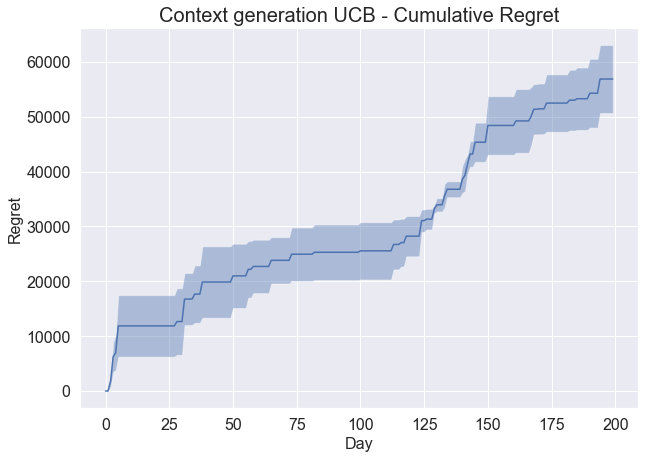

In [266]:

mean_regret_ucb7 = np.mean(np.reshape(ucb_Regret7, [n_exp, T]), axis = 0)
std_dev_regret_ucb7 = np.std(np.reshape(ucb_Regret7, [n_exp, T]), axis=0)/np.sqrt(n_exp)
plt.figure(figsize = (10,7))
plt.plot(mean_regret_ucb7)
plt.fill_between(range(T),mean_regret_ucb7-std_dev_regret_ucb7,mean_regret_ucb7+std_dev_regret_ucb7,alpha =0.4)
plt.title("Context generation UCB - Cumulative Regret", fontsize = 20)
plt.ylabel("Regret", fontsize = 16)
plt.xlabel("Day", fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

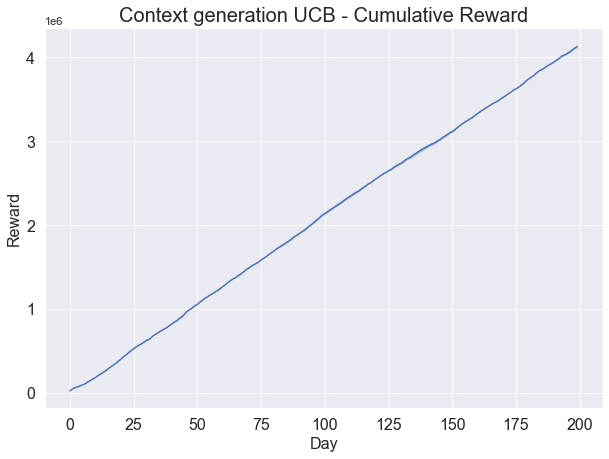

In [268]:
mean_reward_ucb7 = np.mean(np.reshape(ucb_Reward7, [n_exp, T]), axis = 0)
std_dev_reward_ucb7 = np.std(np.reshape(ucb_Reward7, [n_exp, T]), axis=0)/np.sqrt(n_exp)
plt.figure(figsize = (10,7))
plt.plot(mean_reward_ucb7)
plt.fill_between(range(T),mean_reward_ucb7-std_dev_reward_ucb7,mean_reward_ucb7+std_dev_reward_ucb7,alpha =0.4)
plt.title("Context generation UCB - Cumulative Reward", fontsize = 20)
plt.ylabel("Reward", fontsize = 16)
plt.xlabel("Day", fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

In [269]:
average_reward = np.mean(mean_reward_ucb7)
average_regret = np.mean(mean_regret_ucb7)

print("Average reward for TS7-approach: ", average_reward)
print("Average regret for TS7-approach: ", average_regret)

Average reward for TS7-approach:  2084537.2
Average regret for TS7-approach:  30448.836847826107


#### Ts_learner

In [270]:

#initializatio of 4 different types of customer each with a unique pair of binary features
a=b=[0,1]
t=0
customers_list_obj=[]
for i in a:
    for j in b:
        customers_list_obj.append(customer(cr,i,j))
        

    
#####ts######
ts_Regret7 = []
ts_Reward7 = []

#creating the enviroment
env=Environment7(conversion_rates, margins, click_prob, avg_items, alpha_params, N_parameters)


for n in range(1):    
    
     #####ts######
    instant_regret_ts7 = []
    instant_reward_ts7 = []
    ts_list = []
    #the function return a list with one learner, the learner is a TS and it considers all customers together
    ts_list=creation_of_ts(customers_list_obj,customers_list_obj,cr)    
    instant_regret = []
    for t in range (0,T):
        
        # evry 14 days  check if we should divide the customers
        if t%14 ==0 and t !=0 :
            #the function return a dictionary, which contain the segmentation of the customers 
            division=split_number_of_customer(customers_list_obj,k, cp, margins,  N)
            new_segmentation=division['split']
            # create a number of learner equal to the split found above

            #creatinon of ts
            ts_list=creation_of_ts(customers_list_obj,new_segmentation,cr)


            #####ts####
        instant_reward_per_agent_ts=0
        for agent_ts in (ts_list):
                #interact
                pulled_arm = agent_ts.pull_arm(k,cp,m,agent_ts.alpha_param,agent_ts.n_items_param)
                _, _, total_reward, X, n_items_dataset, alpha_sampled, Ns, features_dataset,_= env.round_entire_day(pulled_arm,agent_ts.type_of_customer)
                agent_ts.update(pulled_arm,X, n_items_dataset, alphas_dataset, Ns)
                #save

                #sum the reward per all the agents
                instant_reward_per_agent_ts +=total_reward

                #store the data
                idx=position_customer(customers_list_obj,agent_ts.type_of_customer)
                for pos in range(len(idx)):
                    customers_list_obj[pos].update(features_dataset,pulled_arm,Ns)


        instant_regret_ts7.append(max(0,opt - instant_reward_per_agent_ts)) # max since regret cannot be negative
        instant_reward_ts7.append(instant_reward_per_agent_ts)

    
####ts######
    cum_regret_ts7 = np.cumsum(instant_regret_ts7)
    cum_reward_ts7 = np.cumsum(instant_reward_ts7)
    ts_Regret7 = np.append(ts_Regret7,cum_regret_ts7)
    ts_Reward7 = np.append(ts_Reward7,cum_reward_ts7)    
    
    
#####ts######
    
ts_Regret7 = np.array(ts_Regret7)
ts_Reward7 = np.array(ts_Reward7)

/Users/sivhansen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sivhansen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 

In [ ]:
mean_regret_ts7 = np.mean(ts_Regret7,axis =0)
std_dev_regret_ts7 = np.std(ts_Regret7, axis=0)/np.sqrt(n_exp)
plt.figure(figsize = (10,7))
plt.plot(mean_regret_ts7)
plt.fill_between(range(T),mean_regret_ts7-std_dev_regret_ts7,mean_regret_ts7+std_dev_regret_ts7,alpha =0.4)
plt.title("Context generation TS - Cumulative Regret", fontsize = 20)
plt.ylabel("Regret", fontsize = 16)
plt.xlabel("Day", fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

In [ ]:
mean_reward_ts7 = np.mean(ts_Reward7,axis =0)
std_dev_reward_ts7 = np.std(ts_Reward7, axis=0)/np.sqrt(n_exp)
plt.figure(figsize = (10,7))
plt.plot(mean_reward_ts7)
plt.fill_between(range(T),mean_reward_ts7-std_dev_reward_ts7,mean_reward_ts7+std_dev_reward_ts7,alpha =0.4)
plt.title("Context generation TS - Cumulative Reward", fontsize = 20)
plt.ylabel("Reward", fontsize = 16)
plt.xlabel("Day", fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

# Final remarks

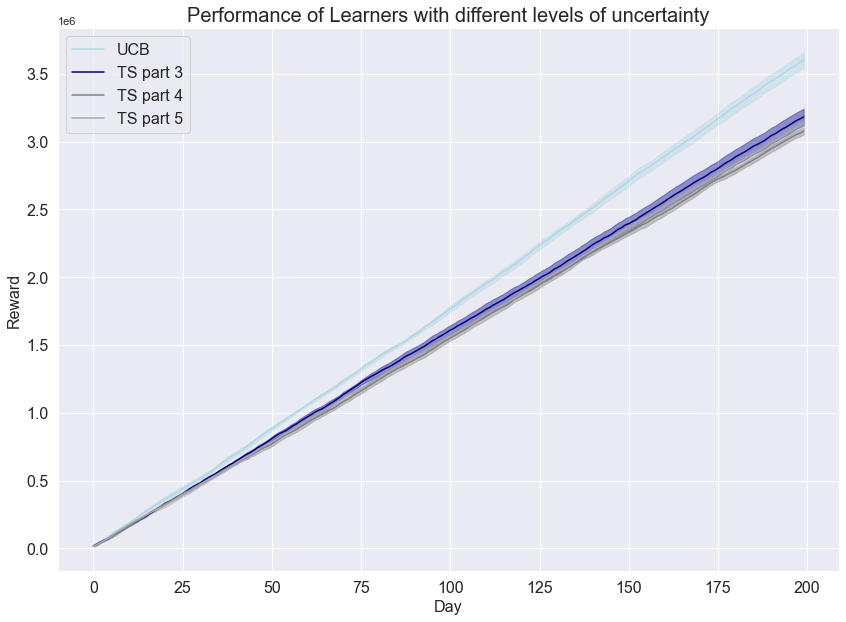

In [234]:
# Examining the different algorihtms
plt.figure(figsize = (14,10))
plt.plot(mean_Reward_ucb3, color='lightblue')
plt.fill_between(range(T),mean_Reward_ucb3-std_dev_ucb3,mean_Reward_ucb3+std_dev_ucb3,alpha =0.4,color='lightblue')

plt.plot(mean_Reward_ts3, color='darkblue')
plt.fill_between(range(T),mean_Reward_ts3-std_dev_ts3,mean_Reward_ts3+std_dev_ts3,alpha =0.4, color='darkblue')

plt.plot(mean_Reward_ts4, color = 'grey')
plt.fill_between(range(T),mean_Reward_ts4-std_dev_ts4,mean_Reward_ts4+std_dev_ts4,alpha =0.4,  color = 'grey')

plt.plot(mean_Reward_ts5, color = 'darkgrey')
plt.fill_between(range(T),mean_Reward_ts5-std_dev_ts5,mean_Reward_ts5+std_dev_ts5,alpha =0.4, color = 'darkgrey')

plt.legend(["UCB","TS part 3","TS part 4", "TS part 5"], fontsize = 16)
plt.title("Performance of Learners with different levels of uncertainty", fontsize = 20)
plt.ylabel("Reward", fontsize = 16)
plt.xlabel("Day", fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

In this project several different versions of UCB1 and Thompson Sampling algorithms have been implemented to optimise the profit for a ecommerce website with 5 different products. The learners are tested in increasingly complex settings: First only the conversion rates are unknown, then also the number of daily customers, how many land on the product pages, number of items they buy and also the probability with which the customers click on the products. Lastly, the algorithms are extended to handle non-stationarity and apply price-discrimination. 

Since the environment is simulated with many different random variables that cause large fluctuations in the daily rewards and the data we observe each day, it is difficult for the learners to obtain stable estimates of these parameters. There is a high degree of stochasticity which complicates the learning process, which is clear from our results. We do not always observe that the cumulative regret stabilises and sometimes it seems to just continue linearly increasing, which indicates that the algorithms are not learning as they should. However, this can be due to many things such as randomnes in the output from the environment or unlucky choices of e.g. conversion rates (we have, however, experimented with different conversion rates, margins graphs etc., but have not found a setting which worked perfectly with the learners). 